Solving the radiative transfer equation for a single atmospheric layer using the discrete ordinates method in Python

by Dion HO Jia Xu

In [1]:
# Required by PyDISORT
import numpy as np
import scipy as sc
from inspect import signature
from math import pi
from numpy.polynomial import legendre
from scipy import integrate

In [2]:
# Only required in this notebook for tests and exposition
import disort
import autograd as ag
import autograd.numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from IPython.display import Image

# Table of Contents
* [1. USER INPUT REQUIRED: Choose parameters -- TODO](#1.-USER-INPUT-REQUIRED:-Choose-parameters----TODO)
	* [1.1 Choose optical properties of atmospheric layers, excluding phase function](#1.1-Choose-optical-properties-of-atmospheric-layers,-excluding-phase-function)
	* [1.2 Choose computational variables](#1.2-Choose-computational-variables)
	* [1.3 Choose phase functions and compute their Legendre coefficients](#1.3-Choose-phase-functions-and-compute-their-Legendre-coefficients)
		* [1.3.1 $\delta-M$ scaling of Legendre coefficients](#1.3.1-$\delta-M$-scaling-of-Legendre-coefficients)
	* [1.4 Choose sources and boundary conditions](#1.4-Choose-sources-and-boundary-conditions)
* [2. Tensor product coding philosophy and importing the PyDISORT module -- TODO](#2.-Tensor-product-coding-philosophy-and-importing-the-PyDISORT-module----TODO)
* [3. Breakdown and verification of single layer solver](#3.-Breakdown-and-verification-of-single-layer-solver)
	* [3.1 Quadrature](#3.1-Quadrature)
		* [3.1.1 Verification of quadrature weights and points on test integral](#3.1.1-Verification-of-quadrature-weights-and-points-on-test-integral)
		* [3.1.2 Normalization verification of the phase function](#3.1.2-Normalization-verification-of-the-phase-function)
	* [3.2 Derivation of the integro-differential equation for each Fourier mode](#3.2-Derivation-of-the-integro-differential-equation-for-each-Fourier-mode)
	* [3.3 $\delta-M$ scaling in the Radiative Transfer Equation](#3.3-$\delta-M$-scaling-in-the-Radiative-Transfer-Equation)
	* [3.4 Derivation of the system of ODEs for each Fourier mode](#3.4-Derivation-of-the-system-of-ODEs-for-each-Fourier-mode)
		* [3.4.1 Choosing the number of Legendre coefficients, quadrature points and loops](#3.4.1-Choosing-the-number-of-Legendre-coefficients,-quadrature-points-and-loops)
	* [3.5 Solving the system of ODEs for each Fourier mode](#3.5-Solving-the-system-of-ODEs-for-each-Fourier-mode)
	* [3.6 Constructing the general solution for each Fourier mode](#3.6-Constructing-the-general-solution-for-each-Fourier-mode)
		* [3.6.1 The particular solution](#3.6.1-The-particular-solution)
		* [3.6.2 The homogeneous solution](#3.6.2-The-homogeneous-solution)
		* [3.6.3 Verification of the general solution](#3.6.3-Verification-of-the-general-solution)
	* [3.7 The full solution](#3.7-The-full-solution)
		* [3.7.1 Verification and visualization of full solution with no corrections](#3.7.1-Verification-and-visualization-of-full-solution-with-no-corrections)
		* [3.7.2 Nakajima-Tanaka corrections -- TODO](#3.7.2-Nakajima-Tanaka-corrections----TODO)
		* [3.7.3 Verification of NT corrected full solution](#3.7.3-Verification-of-NT-corrected-full-solution)
		* [3.7.4 Computation of flux](#3.7.4-Computation-of-flux)
			* [3.7.4.1 Verification of flux](#3.7.4.1-Verification-of-flux)
			* [3.7.4.2 Reflectance and transmittance](#3.7.4.2-Reflectance-and-transmittance)
		* [3.7.5 Timing PyDISORT](#3.7.5-Timing-PyDISORT)
* [4. Solving for multiple atmospheric layers -- TODO](#4.-Solving-for-multiple-atmospheric-layers----TODO)
* [5. Comparisons with Stamnes' FORTRAN DISORT -- TODO](#5.-Comparisons-with-Stamnes'-FORTRAN-DISORT----TODO)


Denote the optical depth as $\tau$, the cosine of the polar angle as $\mu$ (positive is upward), and the azimuthal angle as $\phi$ (positive is counterclockwise when looking down on the atmospheric layer). We wish to solve the Radiative Transfer Equation

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

with Dirichlet boundary conditions for the **diffuse** intensity, $u = u_\text{diffuse}$. This will be done numerically using the Discrete Ordinates Method as is standard. Our Discrete Ordinates Method algorithm is called PyDISORT. The total intensity is given by

$$u_\text{total} = u_\text{diffuse} + u_\text{direct}$$

where 

$$
\begin{aligned}
&\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

The fundamental idea behind the Discrete Ordinates Method from Chandrasekhar [[1]](#cite-Cha1960) is to perform the following series expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0}^\text{NLoops} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series expansion)}\\
p\left(\cos\gamma\right) &\approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1) g_\ell P_\ell\left(\cos\gamma\right) \quad \text{(Legendre series expansion)}
\end{aligned}
$$

and approximate the $\mu'$ integral using Gauss-Legendre quadrature with $\text{NQuad} =: 2N$ quadrature points, i.e.

$$\int_{-1}^1 [\dots] \ \mathrm{d}\mu' = \sum_{j=1}^\text{NQuad} [\dots]$$

# 1. USER INPUT REQUIRED: Choose parameters -- TODO

*TODO: Edit variables for multiple atmopsheric layers. Right now the code and exposition is only for one atmospheric layer.*

Our notations generally follow those in Stamnes et. al.'s 1988 paper [[2]](#cite-STWJ1988), with the equivalent variable in their FORTRAN DISORT code [[3]](#cite-Sta1999) in brackets, though Stamnes' DISORT and our PyDISORT require somewhat different inputs. The default values we provide correspond to *Test Problem 3: Henyey-Greenstein Scattering* of Stamnes' DISORT but we tweak the values of $\mu_0$, $\phi_0$, $\omega_0$, as well as decrease $\text{NQuad}$ and increase $g$ so that $\delta-M$ scaling, explained in section [1.3.1](#1.3.1-$\delta-M$-scaling-of-Legendre-coefficients), will have a greater effect.

## 1.1 Choose optical properties of atmospheric layers, excluding phase function

* **Optical depth (DTAUC)**

The atmospheric layer is demarcated by $\tau \in [0, \tau_0]$. We implemented Stamnes-Conklin's substitutions [[4]](#cite-SC1984) to accomodate large $\tau_0$ values. Nonetheless, since $\tau_0$ will be exponentiated, large $\tau_0$ values will still cause inaccuracies. We require $\tau_0$ to be positive and values too close to 0 will cause instability.

In [3]:
tau0 = 8

* **Single-scattering albedo (SSALB)**

We assume the single-scattering albedo $\omega_0$ to be independent from $\tau$. We require $\omega_0 \in [0,1)$, and values too close to $1$ will cause instability.

In [4]:
w0 = 0.75

## 1.2 Choose computational variables

* **Whether to only compute the flux, or compute both flux and intensity (ONLYFL)**

If `True`, PyDISORT will be much faster because we will only need to solve the $0$th Fourier mode integro-differential equation, see section [3.7.4](#3.7.4-Computation-of-flux).

In [5]:
only_flux = False

* **Number of quadrature points for the $\mu'$ integral (NSTR)**

This parameter is also known as the number of "streams" in the radiation literature and in Stamnes' DISORT [[3]](#cite-Sta1999). We require $\text{NQuad}$ to be $\geq 2$ and even.

In [6]:
NQuad = 16

We define $N = \text{NQuad} \ / \ 2$. This variable will be used extensively.

In [7]:
N = NQuad // 2

* **Number of loops, also number of Fourier modes in the numerical solution**

See section [3.4.1](#3.4.1-Choosing-the-number-of-Legendre-coefficients,-quadrature-points-and-loops) for an explanation of this parameter and how it is adaptive in Stamnes' DISORT [[3]](#cite-Sta1999). Note that `only_flux = True` overwrites this parameter and is equivalent to `NLoops = 1`, except that `only_flux = True` will also cause the intensity function to not be returned. The number of loops must be positive and cannot exceed the number of phase function Legendre coefficients provided.

In [8]:
NLoops = NQuad

## 1.3 Choose phase functions and compute their Legendre coefficients

We assume that the phase function is only directly dependent on the scattering angle $\gamma$, i.e. the scattering medium has spherical symmetry. Then, we can follow the method in [[2]](#cite-STWJ1988), but with slightly different notations and definitions, and expand the phase function in a Legendre series of $\cos\gamma$:

$$
p(\cos\gamma) \approx \sum_{\ell=0} (2\ell + 1)g_\ell P_\ell(\cos\gamma), \quad g_\ell = \frac{1}{2}\int_{-1}^{1} p(\cos\gamma) P_\ell(\cos\gamma) \mathrm{d}\cos\gamma
$$

The scattering angle $\gamma$ is between the incident vector $\left(\theta', \phi'\right)$ and the scattering vector $(\theta, \phi)$ such that

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
\iff \nu &= \mu' \mu + \sqrt{1 - \mu'^2} \sqrt{1 - \mu^2} \cos\left(\phi'-\phi\right)
\end{aligned}
$$

where we define

$$
\nu = \cos\gamma, \quad \mu = \cos\theta, \quad\mu' = \cos\theta'
$$

Therefore, by the addition theorem for spherical harmonics

$$
P_\ell(\cos\gamma) = P_\ell\left(\cos\theta'\right)P_\ell(\cos\theta) + 2\sum_{m=1}^\ell \frac{(\ell-m)!}{(\ell+m)!}P_\ell^m\left(\cos\theta'\right)P_\ell^m(\cos\theta)\cos\left(m\left(\phi'-\phi\right)\right)
$$

In general, we will use the $\nu$-argument form of a phase function as it is the most straightforward to integrate. In our exposition, however, we will generally express a phase function with arguments $\mu, \phi, \mu', \phi'$ for consistency with the radiative transfer equation.

**Henyey-Greenstein (HG) phase function**

The exact definition varies between sources by a constant factor. The definition here follows [[2]](#cite-STWJ1988), though the phase function is not explicitly defined in that paper:

$$\frac{1-g^2}{\left(1+g^2-2 g \nu\right)^{3 / 2}}$$

In [9]:
p_HG_nu = lambda nu, g: (1 - g**2) / ((1 + g**2 - 2 * g * nu) ** (3 / 2))

**Asymmetry factor (GG)**

The magnitude of $g$ must be less than $1$. Magnitudes close to $1$ will cause instability.

In [10]:
g = 0.9

In [11]:
assert np.abs(g) < 1

* **Phase function Legendre coefficients $g_\ell$ (PMOM)**

**Number of Legendre coefficients (NMOM)**

In [12]:
# Not used in PyDISORT
NLeg_full = 128

For reasons explained in section [3.4.1](#3.4.1-Choosing-the-number-of-Legendre-coefficients,-quadrature-points-and-loops), the number of Legendre coefficients supplied must be less than the number of quadrature points ($\text{NQuad}$). Stamnes' DISORT [[3]](#cite-Sta1999) allows for more Legendre coefficients to be supplied but will use at most $\text{NQuad}$ of them. As the Legendre coefficients are also used for $\delta-M$ scaling, see section [1.3.1](#1.3.1-$\delta-M$-scaling-of-Legendre-coefficients), we recommend storing a long vector of Legendre coefficients but only supplying the correct number to PyDISORT. We require a positive number of Legendre coefficients each with magnitude $<= 1$.

In [13]:
# We have this special formula to calculate the Legendre coefficients of the HG phase function
Leg_coeffs_full = g ** np.arange(NLeg_full)

In [14]:
# Actually supplied to PyDISORT
Leg_coeffs = Leg_coeffs_full[:NQuad]

* **The true phase function with the cosine of the scattering angle $\nu$ as a vector argument**

This needs to be supplied to PyDISORT to enable NT corrections, see section [3.7.2](#3.7.2-Nakajima-Tanaka-corrections----TODO).

In [15]:
p_for_NT = lambda nu: p_HG_nu(nu, g)

**Rayleigh phase function**

In [16]:
p_R_nu = lambda nu: (3 / 4) * (1 + nu**2)

In [17]:
'''
Leg_coeffs = np.array([1, 0, 0.1])
p_for_NT = p_R_nu
'''

'\nLeg_coeffs = np.array([1, 0, 0.1])\np_for_NT = p_R_nu\n'

In [18]:
# Internal variable in PyDISORT: the exact number of Legendre coefficients supplied
NLeg = len(Leg_coeffs)

**Integral derivation of Legendre coefficients for verification**

[Skip verification](#1.3.1-$\delta-M$-scaling-of-Legendre-coefficients)

The following algorithm can be used to derive the Legendre coefficients for a general phase function. The algorithm can also be vectorized, but we would no longer be able to use `scipy.integrate.quad` for integration.

In [19]:
Leg_coeffs_full_test = np.empty(NLeg_full)
for ell in range(NLeg_full):
    integrand = lambda nu: p_HG_nu(nu, g) * sc.special.eval_legendre(ell, nu)
    Leg_coeffs_full_test[ell] = (1 / 2) * integrate.quad(integrand, -1, 1)[0]

assert np.allclose(Leg_coeffs_full, Leg_coeffs_full_test)

print("Passed all tests")

Passed all tests


### 1.3.1 $\delta-M$ scaling of Legendre coefficients

Standard Legendre series approximation of highly anisotropic phase functions require a large number of terms to accurately capture their strong directional scattering. This is due to the slow decay of their Legendre coefficients. Using the HG phase function as an illustrative example, its Legendre coefficients are given by $\zeta_\ell = g^\ell$ where $g$ is the asymmetry factor. It is clear therefore that the closer $|g|$ is to $1$, i.e. the more anisotropic the HG phase function is, the slower its Legendre coefficients will decay.

We can use fewer Legendre terms if we re-express the phase function as a linear combination of a $\delta$-function and a more isotropic remainder. We follow the method in [[6]](#cite-Wis1977) for scaling the first $2M$ Legendre coefficients of a phase function such that they become the coefficients of the remainder.

$$
\begin{aligned}
&p(\cos \gamma) \approx 2 f \delta(1-\cos \gamma) + (1 - f) \sum_{\ell=0}^{2 M-1} (2\ell + 1) g_\ell^* P_\ell(\cos \gamma), \quad g^*_\ell = \frac{g_\ell - f}{1 - f} \\
&\iff p(\mu, \phi; \mu', \phi') \approx 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
\end{aligned}
$$

where $\mu = \cos\theta$, $\mu' = \cos\theta'$, and the fractional scattering into peak $f \in [0, 1)$ is to be chosen, with $f = 0$ equivalent to no $\delta-M$ scaling. The method is equivalent to approximating the truncated coefficients as $f$ instead of $0$ as in standard truncation approximation. The first $2M$ Legendre coefficients of this re-expression will agree with those of the phase function.

We generally choose $f = g_{2M} = g_\text{NLeg}$ so that the first $2M + 1$, and not just $2M$, Legendre coefficients of the re-expression agree with those of the phase function. This is automatically done in Stamnes' DISORT [[3]](#cite-Sta1999). This choice of $f$ with $M = 1$ is equivalent to the delta-Eddington method, see [[7]](#cite-JWW1976). We discuss the impact of this phase function re-expression on the radiative transfer equation in section [3.3](#3.3-$\delta-M$-scaling-in-the-Radiative-Transfer-Equation).

* **Fractional scattering into peak (Automatically chosen in Stamnes' DISORT [[3]](#cite-Sta1999))**

We require $f \in [0, 1)$. Values close to $1$ will cause instability.

In [20]:
f = Leg_coeffs_full[NLeg]

## 1.4 Choose sources and boundary conditions

 * **Dirichlet boundary conditions (No direct equivalent in Stamnes' DISORT [[3]](#cite-Sta1999), but see variable *IBCND*)**

$$
u\left(\tau_0, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLoops}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLoops}}b^-_{im}\cos(m(\phi_0 - \phi)), \quad i = 1, \dots, N
$$

where $b^\pm$ are to be specified.

If $u\left(\tau_0, \mu, \phi \right) = \psi^+(\mu, \phi)$ and $u\left(\tau_0, -\mu, \phi \right) = \psi^-(\mu, \phi)$, then $\psi^+$ and $\psi^-$ must first be discretized in $\mu$, following which $b^+_{im}$ and $b^-_{im}$ are the truncated Fourier coefficients of $\psi^+_i$ and $\psi^-_i$ respectively. The boundary functions $\psi^+$ and $\psi^-$ are assumed to be even about $\phi = \phi_0$. Non-Dirichlet BCs are possible but not implemented.

In [21]:
# These should actually be matrices with row index i and column index m,
# but it is ok for them to be a constant.
# Do NOT input a vector,
# while we can implement code to make sense of vector inputs it would be unnecessarily confusing.

# At bottom of atmosphere
b_pos = 0

# At top of atmosphere
b_neg = 0

Each BC input must be a scalar or a matrix of dimension $N \times \text{NLeg}$.

In [22]:
# This ensures that the BC inputs are of the correct shape
if len(np.atleast_1d(b_pos)) == 1:
    b_pos = np.full((N, NLoops), b_pos)
else:
    assert np.shape(b_pos) == (N, NLoops)
if len(np.atleast_1d(b_neg)) == 1:
    b_neg = np.full((N, NLoops), b_pos)
else:
    assert np.shape(b_neg) == (N, NLoops)

* **Parameters for the incident collimated (direct) beam**

The flux contribution of this beam is $I_0 \mu_0$. We do not allow $\mu_0$ to coincide with a quadrature angle. If that happens either $\text{NQuad}$ or $\mu_0$ should be tweaked. We also do not allow $\mu_0 \leq 0$. The PyDISORT module is not designed to model a beam shining up from the surface into the bottom of the atmosphere. Small $\mu_0$ values will cause instability. Finally, we require both angles to be principal.

In [23]:
# Intensity (FBEAM)
I0 = 200
# Cosine of polar angle (UMU0)
mu0 = 0.5
# Azimuthal angle (PHI0)
phi0 = 1.2 * pi

# 2. Tensor product coding philosophy and importing the PyDISORT module -- TODO

[Skip section](#3.-Breakdown-and-verification-of-single-layer-solver)

When coding tensor products we use the following methods in order of preference:

* Broadcasting: e.g. outer product of `array1` and `array2` is coded as `array1[:, None] * array2[None, :]`.
* NumPy function `einsum` with `optimize = True`: `np.einsum` uses Einstein's summation convention. The documentation can be found at https://numpy.org/doc/stable/reference/generated/numpy.einsum.html.

We believe that this is the best balance between code readability and speed. Other common functions for tensor products are `np.outer` and `np.tensordot` but we do not use them.

We import our PyDISORT module

In [24]:
import PyDISORT # TODO: Implement IMS correction

PyDISORT comes with three sub-modules: `subroutines`, `basic_solver` and `pydisort`. The `basic_solver` and `pydisort` sub-modules each contain a single function of the same name. The `basic_solver` function solves the Radiative Transfer Equation for a single atmospheric layer with no corrections. It should not be called directly and should instead be called through the `pydisort` function. The `subroutines` sub-module contains miscellaneous functions that are used in the `basic_solver` and `pydisort` functions. The functions can also be called directly, as will be done in section [3](#3.-Breakdown-and-verification-of-single-layer-solver).

# 3. Breakdown and verification of single layer solver

In this section we break down and explain the code for solving the radiative transfer equation for a single atmospheric layer. Unless otherwise stated, we will take $\delta-M$ scaling to be disabled (`f == 0`) and we will not apply NT corrections (`callable(p_for_NT) == False`). We will explain $\delta-M$ scaling and NT corrections in their independent sections. We begin with the quadrature algorithms that we will need.

## 3.1 Quadrature

Generation of Gauss-Legendre quadrature weights and points to numerically integrate over $\mu$ from $-1$ to $1$.

In [25]:
# For positive mu values (the weights are identical for both domains)
mu_arr_pos, weights_mu = legendre.leggauss(N)
mu_arr_pos = PyDISORT.subroutines.transform_interval(mu_arr_pos, 0, 1)  # mu_arr_neg = -mu_arr_pos
weights_mu = PyDISORT.subroutines.transform_weights(weights_mu, 0, 1)

Function to generate Clenshaw-Curtis quadrature weights and points for numerical integration over $\phi$. It is not part of the PyDISORT module as it is only required for tests.

In [26]:
def Clenshaw_Curtis_quad(Nphi, c=0, d=(2 * pi)):
    # Ensure that the number of nodes is odd and greater than 2
    assert Nphi > 2
    assert Nphi % 2 == 1

    Nphi -= 1  # The extra index corresponds to the point 0 which we will add later
    Nphi_pos = Nphi // 2
    phi_arr_pos = np.cos(pi * np.arange(Nphi_pos) / Nphi)
    phi_arr = np.hstack((-phi_arr_pos, 0, np.flip(phi_arr_pos)))
    diff = np.hstack((2, 2 / (1 - 4 * np.arange(1, Nphi_pos + 1) ** 2)))
    weights_phi_pos = sc.fft.idct(diff, type=1)
    weights_phi_pos[0] /= 2
    full_weights_phi = np.hstack((weights_phi_pos, np.flip(weights_phi_pos[:-1])))

    return PyDISORT.subroutines.transform_interval(
        phi_arr, c, d
    ), PyDISORT.subroutines.transform_weights(full_weights_phi, c, d)

### 3.1.1 Verification of quadrature weights and points on test integral

[Skip verifications](#3.2-Derivation-of-the-integro-differential-equation-for-each-Fourier-mode)

$$\int_{a}^{b} e^x \ \mathrm{d}x = e^b - e^a$$

In [27]:
# Gauss-Legendre quadrature; integrate from -1 to 1
mu_arr = np.concatenate((mu_arr_pos, -mu_arr_pos))
full_weights_mu = np.concatenate((weights_mu, weights_mu))
true_sol = np.exp(1) - np.exp(-1)


print(
    "Gauss-Legendre quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(mu_arr) * full_weights_mu)) / true_sol),
)

Gauss-Legendre quadrature error ratio = 0.0


In [28]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1   

# Clenshaw-Curtis quadrature; integrate from 0 to 2pi
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)
true_sol = np.exp(2 * pi) - 1


print(
    "Clenshaw-Curtis quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(phi_arr) * full_weights_phi)) / true_sol),
)

Clenshaw-Curtis quadrature error ratio = 2.1270086547936496e-16


### 3.1.2 Normalization verification of the phase function

Similar to equation (2) of [[5]](#cite-MW1980), we expect

$$
\frac{1}{4 \pi} \int_{-1}^1 \int_0^{2 \pi} p\left(\mu, \phi ; \mu^{\prime}, \phi^{\prime}\right) d \phi d \mu = 1
$$

In [29]:
def p_HG_muphi(mu, phi, mu_p, phi_p, g):
    nu = PyDISORT.subroutines.calculate_nu(mu, phi, mu_p, phi_p)
    return p_HG_nu(nu, g)

In [30]:
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)
mu_arr = np.concatenate((mu_arr_pos, -mu_arr_pos))
full_weights_mu = np.concatenate((weights_mu, weights_mu))

normalize_pHG = np.einsum(
    "ijkl, i, j -> kl",
    p_HG_muphi(mu_arr, phi_arr, mu_arr, phi_arr, g),
    full_weights_mu,
    full_weights_phi,
    optimize=True,
) / (4 * pi)

# Evidently the phase function is relatively difficult to integrate by quadrature
print("Max pointwise error ratio =", np.max(np.abs(normalize_pHG - 1)))

Max pointwise error ratio = 0.18221102484512897


## 3.2 Derivation of the integro-differential equation for each Fourier mode

*We will re-derive equations (6a) to (6d) of [[2]](#cite-STWJ1988) in this subsection.*

We wish to turn the problem of solving the radiative transfer equation

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

into the problem of solving

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\tau, \mu, \mu^{\prime}\right) u^m\left(\tau, \mu^{\prime}\right) d \mu^{\prime} - Q^m(\mu, \tau)
$$

for each Fourier mode $m$.

**Definitions and expansions**

We have the definitions and expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series expansion)}\\
p\left(\cos\gamma\right) &\approx \sum_{\ell=0} \zeta_\ell P_\ell\left(\cos\gamma\right) \quad \text{(Legendre series expansion)}
\end{aligned}
$$
$$
\begin{aligned}
\zeta_\ell &= \frac{2\ell + 1}{2}\int_{-1}^{1} p\left(\cos\gamma\right) P_\ell\left(\cos\gamma\right) \mathrm{d}\cos\gamma, \quad &&\zeta_\ell^m = \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!} \zeta_\ell \\
\mu &= \cos\theta, \quad &&\,\mu' = \cos\theta'
\end{aligned}
$$

where $\zeta_\ell$ are the weighted Legendre coefficients, $\zeta_\ell = (2 \ell + 1) g_\ell$. As before, we have

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
P_\ell\left(\cos\gamma\right) &= P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!}P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right)
\end{aligned}
$$

Consequently, we can expand the $\mu, \phi, \mu', \phi'$ form of the phase function as

$$
p\left(\mu, \phi; \mu', \phi'\right) \approx \sum_{\ell=0} \left[ \zeta_\ell P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \zeta_\ell^m P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right) \right]
$$

**Multiple scattering term**

We first focus on the multiple scattering term of the radiative transfer equation. We substitute the expansion of $p(\mu, \phi; \mu', \phi')$ and $u(\tau, \mu, \phi)$ to get

$$
\begin{aligned}
&\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&\approx \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ \int_{0}^{2 \pi} \sum_{n=0} \sum_{\ell=0} u^n \zeta_\ell P_\ell\left(\mu'\right)P_\ell(\mu) \cos\left(n\left(\phi_0 - \phi'\right)\right) + 2\sum_{n=0} \sum_{\ell=0} \sum_{m=1}^\ell u^n \zeta_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \right] \mathrm{d} \mu' \\
&= \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ \int_{0}^{2 \pi} \sum_{\ell=0} u^0 \zeta_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\sum_{n=1} \sum_{\ell=n} \sum_{m=1}^\ell u^n \zeta_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \right] \mathrm{d} \mu' \\
&= \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ 2\pi \sum_{\ell=0} u^0 \zeta_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\pi\sum_{n=1} \sum_{\ell=n} u^n \zeta_\ell^n P_\ell^n(\mu')P_\ell^n(\mu)\cos\left(n\left(\phi_0 - \phi\right)\right) \right] \mathrm{d} \mu' \\
&= \int_{-1}^{1} \sum_{m=0} \left\{ \frac{\omega_0}{2} \sum_{\ell=m} u^m \zeta_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \right\} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \mu'
\end{aligned}
$$

The term in the curly brackets of the last line is the contribution of the multiple scttering term to the $m$th Fourier moment of the radiative transfer equation.

**Source term**

Next, we focus on the source term. Once again, we substitute the expansion of $p(\mu, \phi; \mu', \phi')$ to get

$$
\frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) \approx \frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \left[ \sum_{\ell=0} \zeta_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu) + 2\sum_{\ell=0}\sum_{m=1}^\ell \zeta_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right) \right]
$$

It is immediately apparent that the contribution to the $0$th moment is

$$
\frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} \zeta_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu)
$$

For $n \geq 1$, to determine the contribution to the $n$th moment, we multiply by $\pi^{-1}\cos\left(n\left(\phi_0-\phi\right)\right)$ and integrate over $\phi$ from $0$ to $2\pi$ to get

$$
\begin{aligned}
&\frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=0}\sum_{m=1}^\ell \zeta_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=n}\sum_{m=1}^\ell \zeta_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega_0 I_0}{2 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \sum_{\ell=n} \zeta_\ell^n P_\ell^n\left(-\mu_0\right)P_\ell^n(\mu)
\end{aligned}
$$

Therefore, the contribution of the source term to the $m$th Fourier moment of the radiative transfer equation (we perform the change of variables $m = n$) is

$$
\frac{\omega_0 I_0 (2 - \delta_{0m})}{4 \pi}\exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} \zeta_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
$$

**Important terms and their formulas**

Consequently, for each Fourier mode, $m \geq 0$, we have the integro-differential equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu^{\prime}\right) u^m\left(\tau, \mu^{\prime}\right) d \mu^{\prime} - Q^m(\mu, \tau)
$$

where

$$
\begin{aligned}
D^m\left(\mu, \mu' \right) &= \frac{\omega_0}{2} \sum_{\ell=m} \zeta_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \\
Q^m(\mu, \tau) &= X^m(\mu) \exp\left(-\mu_{0}^{-1} \tau\right) \\
X^m(\mu) &= \frac{\omega_0 I_0 (2 - \delta_{0m})}{4 \pi}\sum_{\ell=0} \zeta_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
\end{aligned}
$$

and our approach will be to solve for each $u^m$ then construct the full solution. Unlike in [[2]](#cite-STWJ1988), our source term $Q$ only contains the "beam" term and not a "thermal" term. We currently do not intend to add the thermal term to PyDISORT.

## 3.3 $\delta-M$ scaling in the Radiative Transfer Equation

Substitute the truncated, $\delta-M$ approximated phase function

$$
p(\mu, \phi; \mu', \phi') = 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
$$

into the radiative transfer equation to get

\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = \ &(1 - \omega_0 f) u(\tau, \mu, \phi) -\frac{(1 - f)\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\omega_0 I_0 \left(f \delta(\mu - \mu_0)\delta(\phi - \phi_0) + \frac{1 - f}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}

Shift the $\delta$-function term to the direct beam to get

$$\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = (1 - \omega_0 f)u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0)$$

We essentially add $\omega_0 f$ of the direct beam that would originally be considered scattered back to the direct beam.

Denote the remaining diffuse intensity as $u^*$, and the augmented direct intensity as $u^*_\text{direct}$. Perform the change of variables

$$\tau^* = (1 - \omega_0 f) \tau \iff \frac{\mathrm{d}\tau}{\mathrm{d}\tau^*} = \frac{1}{1 - \omega_0 f}, 
\quad \omega^*_0 = \frac{1-f}{1 - \omega_0 f} \omega_0$$

to get

$$
\begin{aligned}
\mu \frac{\partial u^*(\tau^*, \mu, \phi)}{\partial \tau^*} = u^*(\tau^*, \mu, \phi) &-\frac{\omega^*_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u^*\left(\tau^*, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$
and
$$
\begin{aligned}
&\mu\frac{\partial u^*_\text{direct}(\tau^*, \mu, \phi)}{\partial\tau^*} = u^*_\text{direct}(\tau^*, \mu, \phi), \quad u^*_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u^*_\text{direct}(\tau^*, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$

This is exactly our starting problem, but with every $\tau$, $\omega_0$, $p$ swapped for $\tau^*$, $\omega^*_0$, $p^*$ respectively. In the literature, $\tau$, $\omega_0$, $p$ are described as having been $\delta-M$ scaled (or just "delta-scaled") to $\tau^*$, $\omega^*_0$, $p^*$. See [[6]](#cite-Wis1977) for more details on $\delta-M$ scaling.

## 3.4 Derivation of the system of ODEs for each Fourier mode

*We will prove equations (7a) and (7b) of [[2]](#cite-STWJ1988) in this subsection.*

In order to solve the integro-differential equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu^{\prime}\right) u^m\left(\tau, \mu^{\prime}\right) d \mu^{\prime} - Q^m(\mu, \tau)
$$

for each Fourier mode $m$, we need to discretize the $\mu$ integral. We split the $\mu$ integral into two integrals: from $-1$ to $0$ and from $0$ to $1$ since there is a singularity at $\mu = 0$. We approximate each integral by Gauss-Legendre quadrature. This is the *double-Gauss method* from [[8]](#cite-Syk1951).

### 3.4.1 Choosing the number of Legendre coefficients, quadrature points and loops

Since $D^m$ is a polynomial in $\mu'$ and we assume that $u^m$ is well-approximated by a polynomial in $\mu'$, Gauss-Legendre quadrature is optimal. A Gauss-Legendre quadrature scheme with $N$ nodes can integrate a polynomial of order $2N - 1$ exactly. Since $D^m$ is a polynomial of order $\text{NLeg} - 1$, the Gauss-Legendre quadrature scheme can integrate $D^m$ exactly when $\text{NLeg} = \text{NQuad}$. Since the integrand also consists of $u^m$, increasing $\text{NQuad}$ past $\text{NLeg}$ remains beneficial. Increasing $\text{NQuad}$ is expensive though, so we generally want to minimize $\text{NQuad}$ while retaining the desired accuracy.

What happens if we choose $\text{NQuad} < \text{NLeg}$? It is known that this will cause large errors, see [[1]](#cite-Cha1960) and [[9]](#cite-STWLE2000), though the reasons are poorly understood. The immediate cause of the errors is likely to be aliasing. Aliasing is a phenomenon that has been well-studied in the context of Discrete Fourier Transforms but not in the context of polynomial interpolation. Recall that Gauss-Legendre quadrature relies on Hermite polynomial interpolation. Why is $\text{NLeg}$ the aliasing threshold? This possibly has to do with the fact that the integrand term $D^m$ is a polynomial of order $\text{NLeg} - 1$ though the full reasons are unknown. 

In summary, conventional wisdom in the Discrete Ordinates Method is to choose $\text{NQuad} = \text{NLeg}$ as the optimal balance between accuracy and computational cost, but there is a lot of room for further research.

An added complication is that realistic phase functions may be very complicated and require many Legendre coefficients to be accurately represented. If $\text{NLeg}$ is large, having even $\text{NQuad} = \text{NLeg}$ may be very expensive. Increasing $\text{NQuad}$ increases computational costs in two ways. First, the size of the systems we need to solve will be larger. Second, there are more Fourier modes $u^m$ which we can solve for to construct the full solution $u$. When $\text{NLeg}$ is large, large systems are needed to prevent aliasing. We, however, do not have to solve for all possible Fourier modes to accurately construct the full solution. Thus, we introduced the parameter $\text{NLoops}$ for the user to choose the number of Fourier modes to use in constructing the full solution. It is so named because we will need to loop our solver $\text{NLoops}$ times. In Stamnes' DISORT, $\text{NLoops}$ is chosen adaptively using the Cauchy convergence criterion. In [[9]](#cite-STWLE2000), see section 3.7: *Azimuthal Convergence*.

**Derivation of the system**

By double-Gauss quadrature, we can approximate the integro-differential equation as


$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{j \neq 0} w_j D^m\left(\mu_i, \mu_j\right) u^m\left(\tau, \mu_j\right) - Q^m(\mu_i, \tau)
$$

For $i,j = 1, \dots, N$, where $2N$ is the number of quadrature points, we define

$$
\begin{aligned}
&\alpha = M^{-1}\left(D^{+} W - I\right) &&\beta = M^{-1} D^{-} W \\
&D^{+}[i,j] = D^m\left(\mu_i, \mu_j\right) = D^m\left(-\mu_i,-\mu_j\right) &&D^{-}[i,j] = D^m\left(-\mu_i, \mu_j\right) = D^m\left(\mu_i,-\mu_j\right) \\
&W[i,j] = w_i\delta_{ij} &&M[i,j] = \mu_i\delta_{ij} \\ 
&u^\pm[i] = u^m(\pm \mu_i) &&Q^{\pm}[i] = Q^m\left(\pm \mu_i, \tau\right) 
\end{aligned}
$$

We also define $\tilde{Q}^\pm = M^{-1} Q^\pm$. We claim that the discretized equation for each Fourier mode can be re-expressed as the system of ODEs

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$

**Proof**

On the RHS, substitute $\alpha, \beta, \tilde{Q}^\pm$:

$$
\begin{aligned}
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} &= \begin{bmatrix} -M^{-1}\left(D^{+} W - I\right) & -M^{-1} D^{-} W \\ M^{-1} D^{-} W & M^{-1}\left(D^{+} W - I\right) \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -M^{-1} Q^+ \\ M^{-1} Q^- \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1} & \\ & M^{-1} \end{bmatrix} \left( \begin{bmatrix} D^{+} W - I & D^{-} W \\ D^{-} W & D^{+} W - I \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right) \\
&= \begin{bmatrix} -\mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & -\mu_N^{-1} & & & \\ & & & \mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & \mu_N^{-1} \end{bmatrix} \left( \left( \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} - I \right) \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right)
\end{aligned}
$$

and so

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} \mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & \mu_N^{-1} & & & \\ & & & -\mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & -\mu_N^{-1} \end{bmatrix} \left(\begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right)
$$

Multiply across by the $\mu_i$ values to see that the system is consistent with the discretized equation for each Fourier mode.

## 3.5 Solving the system of ODEs for each Fourier mode

As previously derived, the system of ODEs for each Fourier mode is

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$

Define $\tilde{Q} = \begin{bmatrix} -\tilde{Q}^+ \tilde{Q}^- \end{bmatrix}^T$ and $\tilde{X} = \exp\left(\mu_0^{-1} \tau\right)\tilde{Q}$. We first address the homogeneous problem, when $\tilde{Q} = 0$, and solve for the eigenpairs of the coefficient matrix from the eigenequation

$$
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} G^+ \\ G^- \end{bmatrix} = k \begin{bmatrix} G^+ \\ G^- \end{bmatrix}
$$

Following the reduction order method in [[2]](#cite-STWJ1988), but with minor sign differences, we can solve

$$
(\alpha - \beta) (\alpha + \beta) \left(G^+ + G^-\right) = k^2 \left(G^+ + G^-\right)
$$

for eigenvalues $k$ which are always real. Given also that

$$
(\alpha + \beta) \left(G^+ + G^-\right) = -k \left(G^+ - G^-\right)
$$

we can solve for $G^+$ and $G^-$. Consequently, we can construct the eigenvector matrix $G = \begin{bmatrix} G^+ & G^- \end{bmatrix}^T$.

In [31]:
m = 2  # We will need to repeat the following blocks of code for NLoops Fourier modes

# Associated Legendre polynomial orders and degrees 
ells = np.arange(m, NLeg)
degree_tile = np.tile(ells, (N, 1)).T

# We transform the Legendre coefficients into WEIGHTED Legendre coefficients
weighted_Leg_coeffs = ((2 * np.arange(NLeg) + 1) * Leg_coeffs).copy()

In [32]:
D_pos, D_neg = PyDISORT.subroutines.generate_Ds(
    m, weighted_Leg_coeffs, mu_arr_pos, w0, ells, degree_tile
)
M_inv = 1 / mu_arr_pos
W = weights_mu[None, :]
alpha = M_inv[:, None] * (D_pos * W - np.eye(N))
beta = M_inv[:, None] * D_neg * W
A = np.vstack((np.hstack((-alpha, -beta)), np.hstack((beta, alpha))))

eigenvals_squared, eigenvecs_GpG = np.linalg.eig((alpha - beta) @ (alpha + beta))
# Eigenvalues arranged negative then positive, from largest absolute value to smallest
eigenvals = np.concatenate((-np.sqrt(eigenvals_squared), np.sqrt(eigenvals_squared)))
eigenvecs_GpG = np.hstack((eigenvecs_GpG, eigenvecs_GpG))
eigenvecs_GmG = (alpha + beta) @ eigenvecs_GpG / -eigenvals

# Eigenvectors
G_pos = (eigenvecs_GpG + eigenvecs_GmG) / 2
G_neg = (eigenvecs_GpG - eigenvecs_GmG) / 2
G = np.vstack((G_pos, G_neg))

**Verification of eigenpairs**

[Skip verification](#3.6-Constructing-the-general-solution-for-each-Fourier-mode)

In [33]:
assert np.allclose((A @ G) / eigenvals, G)
print("Passed all tests")

Passed all tests


## 3.6 Constructing the general solution for each Fourier mode

For each Fourier mode $m$, the general solution is

$$
u^m = v^m + w^m
$$

where $v$, $w$ denotes the homogeneous and particular solutions respectively. We will omit the superscript $m$ going forward.

### 3.6.1 The particular solution

The particular solution (vector), $v$, satisfies

$$
\frac{\mathrm{d}v}{\mathrm{d}\tau} = A v + \tilde{Q}
$$

where

$$
A = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix}, \quad \tilde{Q} = \tilde{X} \exp\left(-\mu_0^{-1} \tau\right)
$$

Assume the ansatz

$$
v(\tau) = B\exp\left(-\mu_0^{-1} \tau\right)
$$

for $B$ to be determined. Substitution into the full equation gives

\begin{aligned}
&-\mu_0^{-1} B\exp\left(-\mu_0^{-1} \tau\right) = AB\exp\left(-\mu_0^{-1} \tau\right) + \tilde{X}\exp\left(-\mu_0^{-1} \tau\right) \\
&\implies -\mu_0^{-1} B = AB + \tilde{X} \\
&\implies -\left(\mu_0^{-1} I + A\right)B = \tilde{X}
\end{aligned}

which we can solve for $B$.

In [34]:
X_pos, X_neg = PyDISORT.subroutines.generate_Xs(
    m, weighted_Leg_coeffs, w0, mu0, I0, mu_arr_pos, ells, degree_tile
)
X_tilde = np.concatenate((-M_inv * X_pos, M_inv * X_neg))

B = np.linalg.solve(-(np.eye(NQuad) / mu0 + A), X_tilde)

**Verification of particular solution**

[Skip verification](#3.6.2-The-homogeneous-solution)

In [35]:
Ntau = 10 # Number of tau test points
tau_arr = np.random.random(Ntau) * tau0

In [36]:
LHS = np.sum(
    ag.jacobian(lambda tau: B[:, None] * np.exp(-tau[None, :] / mu0))(tau_arr), axis=-1
)
RHS = A @ B[:, None] * np.exp(-tau_arr[None, :] / mu0) + X_tilde[:, None] * np.exp(
    -tau_arr[None, :] / mu0
)


print("Max pointwise error ratio = ", np.max(np.abs((RHS - LHS) / LHS)))

Max pointwise error ratio =  1.1471719984913797e-14


### 3.6.2 The homogeneous solution

The homogeneous solution (vector), $w$, can be split into

$$
w = \begin{bmatrix} w^+ \\ w^- \end{bmatrix}, \quad  w^\pm(\tau) = G^\pm \text{Diag}(K(\tau)) \xi
$$

where $K(\tau)[j] = \exp(k_j\tau)$ and the coefficient vector $\xi$ is to be determined from the boundary conditions. Given $\tau \in [0, \tau_0]$ and Dirichlet BCs 

$$
w^-(0) = b^-_m, \quad w^+\left( \tau_0 \right) = b^+_m
$$

where $b^\pm_m$ is the $m$th column of matrix $b^\pm$, we have by superposition

$$
w^-(0) = b^-_m - B^-, \quad w^+\left( \tau_0 \right) = b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right)
$$

This produces the system

$$
\begin{bmatrix} G^- \\ G^+ \text{Diag}(K(\tau_0))  \end{bmatrix} \xi = \begin{bmatrix} b^-_m - B^- \\ b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right) \end{bmatrix}
$$

which we can solve to determine $\xi$.

**Stamnes-Conklin's substitutions to address ill-conditioning**

The problem with the above formulation is that for large $\tau_0$, the terms in $K\left(\tau_0\right)$ that correspond to positive eigenvalues will be large. This may result in overflow or at least an ill-conditioned system. A solution to this problem is given by Stamnes and Conklin in [[4]](#cite-SC1984). First, re-express the system as

$$
\begin{bmatrix} G^{--} & G^{-+} \\ G^{+-} \text{Diag}\left(K^-\left(\tau_0\right)\right) & G^{++} \text{Diag}\left(K^+\left(\tau_0\right)\right) \end{bmatrix} \begin{bmatrix} \xi^- \\ \xi^+ \end{bmatrix} = \begin{bmatrix} b^-_m - B^- \\ b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0 \right) \end{bmatrix}
$$

where $K^\pm\left(\tau_0\right)$, $G^{-\pm}$ and $G^{+\pm}$ correspond to positive and negative eigenvalues respectively. Recall that the eigenvalues are arranged negative then positive, e.g. $G^+ \text{Diag}\left(K\left(\tau_0\right)\right) = \begin{bmatrix} G^{+-} \text{Diag}\left(K^-\left(\tau_0\right)\right) & G^{++} \text{Diag}\left(K^+\left(\tau_0\right)\right) \end{bmatrix}$. 

Next, substitute $\xi^- = C^-$ and $\xi^+ = C^+ \text{Diag}\left(K^-\left(\tau_0\right)\right)$ to get

$$
\begin{bmatrix} G^{--} & G^{-+} \text{Diag}\left(K^-\left(\tau_0\right)\right) \\ G^{+-} \text{Diag}\left(K^-\left(\tau_0\right)\right) &  G^{++} \end{bmatrix} \begin{bmatrix} C^- \\ C^+ \end{bmatrix} = \begin{bmatrix} b^-_m - B^-  \\ b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0 \right) \end{bmatrix}
$$

This reformulated system has no positive exponents so there is no risk of overflow. Furthermore, when $\tau_0$ is large the matrix becomes approximately block diagonal and so it remains well-conditioned. We solve for $C$ and do not construct $\xi$ because we will use the factor of $\text{Diag}\left(K^-\left(\tau_0\right)\right)$ to avoid positive exponents when we construct the general solution. This method is easily generalizable to multiple atmospheric layers, see section [4](#4.-Solving-for-multiple-atmospheric-layers----TODO).

**Solving the system naively**

In [37]:
B_pos, B_neg = B[:N], B[N:]
K_tau0 = np.exp(eigenvals * tau0)

LHS = np.vstack((G_neg, G_pos * K_tau0[None, :]))
print("Condition number =", np.linalg.cond(LHS))
RHS = np.concatenate((b_neg[:, m] - B_neg, b_pos[:, m] - B_pos * np.exp(-tau0 / mu0)))
# The system is too ill-conditioned to be solved if tau0 is large
xi = np.linalg.solve(LHS, RHS)

Condition number = 3.6434610161943145e+158


**Solving the system with Stamnes-Conklin's substitutions**

In [38]:
B_pos, B_neg = B[:N], B[N:]
K_tau0_neg = np.exp(eigenvals[:N] * tau0)

LHS = np.vstack((G_neg, G_pos))
LHS[:N, N:] *= K_tau0_neg[None, :]
LHS[N:, :N] *= K_tau0_neg[None, :]
print("Condition number =", np.linalg.cond(LHS))
RHS = np.concatenate((b_neg[:, m] - B_neg, b_pos[:, m] - B_pos * np.exp(-tau0 / mu0)))
C = np.linalg.solve(LHS, RHS)

Condition number = 1.5477816409379779


Finally, we have the general solution for one Fourier mode $m$.

In [39]:
# The general solution for one Fourier mode

# Note that we use the factor of Diag(K_-(\tau_0)) attached to the coefficients (see Section 3.6.2)
# to avoid positive exponents when we construct the general solution for one Fourier mode
def um(tau):
    tau = np.atleast_1d(tau)
    exponent = np.vstack(
        (
            eigenvals[:N, None] * tau[None, :],
            eigenvals[N:, None] * (tau - tau0)[None, :],
        )
    )
    return (G * C[None, :]) @ np.exp(exponent) + B[:, None] * np.exp(
        -tau[None, :] / mu0
    )

### 3.6.3 Verification of the general solution

[Skip verifications](#3.7-The-full-solution)

**Does the general solution satisfy the BCs?**

In [40]:
# At top of atmosphere
assert np.allclose(um(0)[N:], b_neg)

# At bottom of atmosphere
assert np.allclose(um(tau0)[:N], b_pos)
print("Passed all tests")

Passed all tests


**Does the general solution satisfy the system of ODEs?**

In [41]:
LHS = np.sum(ag.jacobian(um)(tau_arr), axis=-1)
RHS = A @ um(tau_arr) + X_tilde[:, None] * np.exp(-tau_arr[None, :] / mu0)

print(
    "Max pointwise error ratio = ",
    np.max(np.abs((RHS - LHS) / LHS)),
)

Max pointwise error ratio =  1.9758610417308857e-12


**Does the general solution satisfy the Fourier mode integro-differential equation?**

In [42]:
D = np.hstack((np.vstack((D_pos, D_neg)), np.vstack((D_neg, D_pos))))
LHS = mu_arr[:, None] * np.sum(ag.jacobian(um)(tau_arr), axis=-1)
RHS = (
    um(tau_arr)
    - np.einsum("ij, jt, j -> it", D, um(tau_arr), full_weights_mu, optimize=True)
    - np.concatenate((X_pos, X_neg))[:, None] * np.exp(-tau_arr[None, :] / mu0)
)

print(
    "Max pointwise error ratio = ",
    np.max(np.abs((RHS - LHS) / LHS)),
)

Max pointwise error ratio =  2.001076927940661e-12


## 3.7 The full solution

The above must be repeated for $\text{NLoops}$ Fourier modes. The full numerical solution given by PyDISORT is

$$
\sum_{m=0}^\text{NLoops} u^m(\mu_i,\tau)\cos\left(m\left(\phi_0 - \phi\right)\right) \approx u(\mu, \tau, \phi)
$$

This solution is continuous and variable in $\tau$ and $\phi$ but discrete in $\mu$ and fixed to the quadrature points. Perform Hermite polynomial interpolation to evaluate the function at other $\mu$ values. The function output is 3D and axes $0, 1, 2$ capture $\mu, \tau, \phi$ variation respectively. The first half of the $\mu$ indices correspond to $u^+$ (upward) and the second half to $u^-$ (downward).

**IMPORTANT:** Reminder that PyDISORT will output the **diffuse intensity**. Add the intensity of the direct beam to get the total intensity.

### 3.7.1 Verification and visualization of full solution with no corrections

[Skip verifications](#3.7.2-Nakajima-Tanaka-corrections----TODO)

In [43]:
# Call PyDISORT from module
mu_arr, u = PyDISORT.pydisort(
    b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0
)[:2]

In [44]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)

full_weights_mu = np.concatenate((weights_mu, weights_mu))

**Does the full solution satisfy the BCs?**

In [45]:
# At top of atmosphere
assert np.allclose(
    u(0, phi_arr)[N:, :], b_neg @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr))
)

# At bottom of atmosphere
assert np.allclose(
    u(tau0, phi_arr)[:N, :],
    b_pos @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)),
)
print("Passed all tests")

Passed all tests


**Does the full solution satisfy the radiative transfer equation?**

`mu_arr` is arranged as it is for code efficiency and readability. For presentation purposes we re-arrange `mu_arr` from smallest to largest.

In [46]:
reorder_mu = np.argsort(mu_arr)

full_weights_mu_RO = full_weights_mu[reorder_mu]
mu_arr_RO = mu_arr[reorder_mu]

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

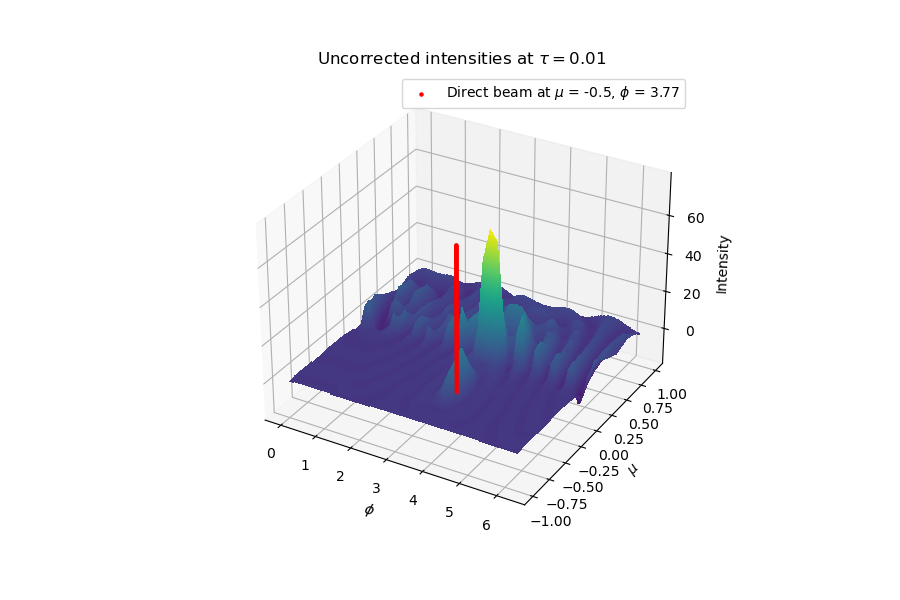

In [47]:
%matplotlib widget

tau_pt = 1e-2  # Must be a float for auto-differentiation to work

plot = u(tau_pt, phi_arr)[reorder_mu]

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(0, np.max(plot) * 1.1, 200),
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Intensity")
plt.title(r"Uncorrected intensities at $\tau =$" + str(np.around(tau_pt, 3)))
plt.legend()

In [48]:
LHS = (
    mu_arr_RO[:, None] * ag.jacobian(lambda tau: u(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS = (
    u(tau_pt, phi_arr)[reorder_mu]
    - (w0 / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr, g),
        u(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (w0 * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0, g)
    * np.exp(-tau_pt / mu0)
)
error = np.abs(RHS - LHS)

In [49]:
print("At tau = " + str(tau_pt))
print("Max pointwise error = ", np.max(error))
# We use clip so as to not divide by quantities too close to 0
print(
    "Max pointwise error ratio =",
    np.max(error / np.clip(np.abs(LHS), a_min=1e-3, a_max=None)),
)

At tau = 0.01
Max pointwise error =  190.13837242210906
Max pointwise error ratio = 1606.2823783216177


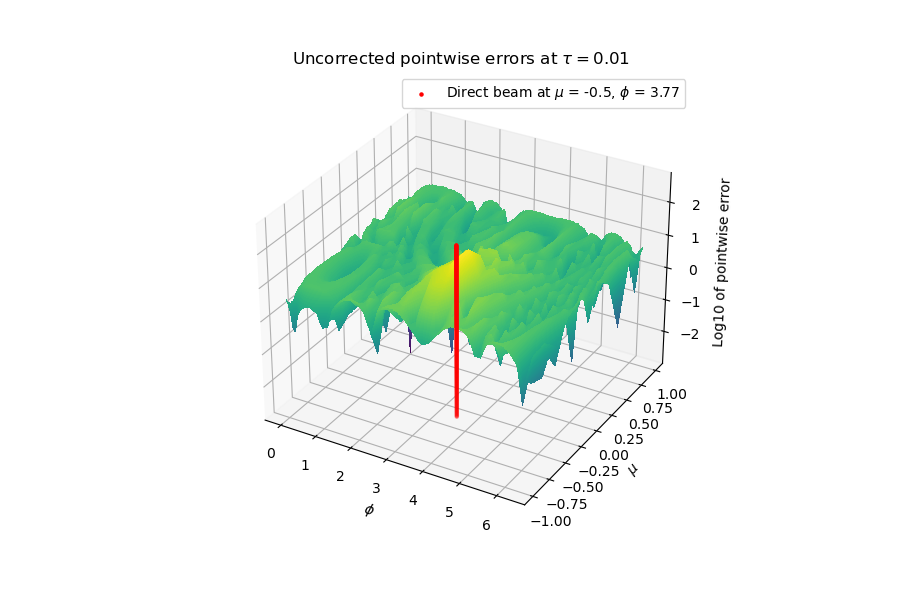

In [50]:
%matplotlib widget

plot = np.log10(error)

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(np.min(plot), np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Log10 of pointwise error")
plt.title(r"Uncorrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

The following is the code for using finite difference instead of auto-differentiation to perform the analysis. Auto-differentiation does not work on the results from Stamnes' DISORT. Be careful of the fact that the finite difference method will itself introduce substantial errors.

In [51]:
'''# Use finite difference instead of auto-differentiation 
# FD is necessary to analyze the error for Stamnes' DISORT,
# but the FD will itself incur large inaccuracies
Ntau_deriv = int(tau0 * 1000) + 1  # Number of tau grid points for finite difference

tau_arr_deriv = np.linspace(0, tau0, Ntau_deriv)
h = tau_arr_deriv[1] - tau_arr_deriv[0]  # grid spacing

# Construct 1st derivative matrix with 2nd order accuracy
first_deriv = np.zeros((Ntau_deriv, Ntau_deriv))
diagonal = np.ones(Ntau_deriv) / (2 * h)
first_deriv += np.diag(diagonal[:-1], 1)
first_deriv += np.diag(-diagonal[:-1], -1)
first_deriv = first_deriv[1:-1, :].T # This is due to tau being indexed by columns instead of rows'''

"# Use finite difference instead of auto-differentiation \n# FD is necessary to analyze the error for Stamnes' DISORT,\n# but the FD will itself incur large inaccuracies\nNtau_deriv = int(tau0 * 1000) + 1  # Number of tau grid points for finite difference\n\ntau_arr_deriv = np.linspace(0, tau0, Ntau_deriv)\nh = tau_arr_deriv[1] - tau_arr_deriv[0]  # grid spacing\n\n# Construct 1st derivative matrix with 2nd order accuracy\nfirst_deriv = np.zeros((Ntau_deriv, Ntau_deriv))\ndiagonal = np.ones(Ntau_deriv) / (2 * h)\nfirst_deriv += np.diag(diagonal[:-1], 1)\nfirst_deriv += np.diag(-diagonal[:-1], -1)\nfirst_deriv = first_deriv[1:-1, :].T # This is due to tau being indexed by columns instead of rows"

In [52]:
'''LHS_Stamnes = mu_arr_RO[:, None, None] * np.einsum("itp, tj -> ijp", uu, first_deriv)
RHS_Stamnes = (
    uu
    - (w0 / (4 * pi))
    * np.einsum(
        "ijkl, ktl, k, l -> itj",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr, g),
        uu,
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (w0 * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0, g)[:, None, :]
    * np.exp(-tau_arr_deriv[None, :, None] / mu0)
)[:, 1:-1, :]

error_Stamnes = np.abs(RHS_Stamnes - LHS_Stamnes)'''

'LHS_Stamnes = mu_arr_RO[:, None, None] * np.einsum("itp, tj -> ijp", uu, first_deriv)\nRHS_Stamnes = (\n    uu\n    - (w0 / (4 * pi))\n    * np.einsum(\n        "ijkl, ktl, k, l -> itj",\n        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr, g),\n        uu,\n        full_weights_mu_RO,\n        full_weights_phi,\n        optimize=True,\n    )\n    - (w0 * I0 / (4 * pi))\n    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0, g)[:, None, :]\n    * np.exp(-tau_arr_deriv[None, :, None] / mu0)\n)[:, 1:-1, :]\n\nerror_Stamnes = np.abs(RHS_Stamnes - LHS_Stamnes)'

In [53]:
'''max_error_index = np.unravel_index(error_Stamnes.argmax(), LHS_Stamnes.shape)

print(
    "Global max pointwise error at",
    np.around(
        (
            mu_arr[max_error_index[0]],
            tau_arr_deriv[max_error_index[1]],
            phi_arr[max_error_index[2]],
        ),
        3,
    ),
)
print("Max pointwise error = ", np.max(error_Stamnes))
print()
# We use clip so as to not divide by quantities too close to 0
print(
    "Max pointwise error ratio = ",
    np.max(error_Stamnes / np.clip(np.abs(LHS_Stamnes), a_min=1e-3, a_max=None)),
)'''

'max_error_index = np.unravel_index(error_Stamnes.argmax(), LHS_Stamnes.shape)\n\nprint(\n    "Global max pointwise error at",\n    np.around(\n        (\n            mu_arr[max_error_index[0]],\n            tau_arr_deriv[max_error_index[1]],\n            phi_arr[max_error_index[2]],\n        ),\n        3,\n    ),\n)\nprint("Max pointwise error = ", np.max(error_Stamnes))\nprint()\n# We use clip so as to not divide by quantities too close to 0\nprint(\n    "Max pointwise error ratio = ",\n    np.max(error_Stamnes / np.clip(np.abs(LHS_Stamnes), a_min=1e-3, a_max=None)),\n)'

In [54]:
'''%matplotlib widget

index = 10

plot = uu[:, index, :]

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(0, np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Intensity")
plt.title(
    r"Stamnes' DISORT intensities at $\tau$ = "
    + str(np.around(tau_arr_deriv[index], 3))
)
plt.legend()'''

'%matplotlib widget\n\nindex = 10\n\nplot = uu[:, index, :]\n\nfig = plt.figure(figsize=(9, 6))\nax = plt.axes(projection="3d")\nax.contourf(MU_ARR, PHI_ARR, plot, 200)\nax.scatter(\n    phi0,\n    -mu0,\n    np.linspace(0, np.max(plot), 200) * 1.1,\n    marker=".",\n    color="red",\n    label="Direct beam at $\\mu$ = "\n    + str(-mu0)\n    + ", $\\phi$ = "\n    + str(np.around(phi0, 3)),\n)\nax.set_xlabel(r"$\\phi$")\nax.set_ylabel(r"$\\mu$")\nax.set_zlabel("Intensity")\nplt.title(\n    r"Stamnes\' DISORT intensities at $\tau$ = "\n    + str(np.around(tau_arr_deriv[index], 3))\n)\nplt.legend()'

In [55]:
'''print("At tau = " + str(tau_arr_deriv[index]))
print("Max pointwise error = ", np.max(error_Stamnes[:, index, :]))
# We use clip so as to not divide by quantities too close to 0
print(
    "Max pointwise error ratio =",
    np.max(
        error_Stamnes[:, 8, :]
        / np.clip(np.abs(LHS_Stamnes[:, 8, :]), a_min=1e-3, a_max=None)
    ),
)'''

'print("At tau = " + str(tau_arr_deriv[index]))\nprint("Max pointwise error = ", np.max(error_Stamnes[:, index, :]))\n# We use clip so as to not divide by quantities too close to 0\nprint(\n    "Max pointwise error ratio =",\n    np.max(\n        error_Stamnes[:, 8, :]\n        / np.clip(np.abs(LHS_Stamnes[:, 8, :]), a_min=1e-3, a_max=None)\n    ),\n)'

In [56]:
'''%matplotlib widget

plot = np.log10(error_Stamnes[:, index, :])

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(np.min(plot), np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Pointwise error")
plt.title(
    r"Stamnes' DISORT Pointwise error at $\tau$ = "
    + str(np.around(tau_arr_deriv[index], 3))
)
plt.legend()'''

'%matplotlib widget\n\nplot = np.log10(error_Stamnes[:, index, :])\n\nfig = plt.figure(figsize=(9, 6))\nax = plt.axes(projection="3d")\nax.contourf(MU_ARR, PHI_ARR, plot, 200)\nax.scatter(\n    phi0,\n    -mu0,\n    np.linspace(np.min(plot), np.max(plot), 200) * 1.1,\n    marker=".",\n    color="red",\n    label="Direct beam at $\\mu$ = "\n    + str(-mu0)\n    + ", $\\phi$ = "\n    + str(np.around(phi0, 3)),\n)\nax.set_xlabel(r"$\\phi$")\nax.set_ylabel(r"$\\mu$")\nax.set_zlabel("Pointwise error")\nplt.title(\n    r"Stamnes\' DISORT Pointwise error at $\tau$ = "\n    + str(np.around(tau_arr_deriv[index], 3))\n)\nplt.legend()'

### 3.7.2 Nakajima-Tanaka corrections -- TODO

This subsection summarizes the main points from [[10]](#cite-NT1988) and from Appendix A of [[9]](#cite-STWLE2000) but omits most of the mathematical explanation. Recall that $\tau^*, \omega^*_0, p^*$ denote $\delta-M$ scaled parameters and $f$ is the scattering fraction into peak. Supply the true phase function with scattering angle $\nu$ as a vector argument through the `p_for_NT` variable to enable Nakajima-Tanaka (NT) corrections.

The $\delta-M$ method allows for accurate flux computation, but intensity values remain inaccurate particularly at backscattering angles and around the direct beam. The inaccuracies are largely caused by the truncation of the Legendre series of the phase function. Nakajima and Tanaka use perturbation theory to reduce the truncation error. This correction is applied to the intensity but not to the flux as the latter is already accurate. This unfortunately means that flux values calculated by integrating the intensity will differ slightly from values given by the flux functions.

**Notations**

We use the functional notation $\mathcal{F}(u, \tau, \omega_0, p; J)$ to denote the radiative transfer equation with a general source function $J$,

$$
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) -\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' - J
$$

For example, the original radiative transfer equation is denoted

$$\mathcal{F}\left(u, \tau, \omega_0, p; \frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)\right)$$

using this notation. The NT correction method can be considered an extension of the $\delta-M$ method. For the $\delta-M$ method, we approximate $u_\text{true} \approx u^*$
where $u_\text{true}$ is the true solution to the original radiative transfer equation, and $u^*$ is the true solution to 

$$\mathcal{F}\left(u^*, \tau^*, \omega^*_0, p^*; \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right)$$

There is no truncation error in the numerical solution for $u^*$ since $p^*$ is defined as a truncated phase function and we use every term.

**TMS correction**

For the first of two NT corrections, named *TMS*, we approximate $u_\text{true} \approx u_\text{TMS} := u^* - u_1^* + \tilde{u}_1^*$, where $u_1^*$ and $\tilde{u}_1^*$ are true solutions to the single-scattering equations

$$\mathcal{F}\left(u_1^*, \tau^*, 0, 0; \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right), \quad \mathcal{F}\left(\tilde{u}_1^*, \tau^*, 0, 0; \frac{\omega^*_0 I_0}{(1 - f) 4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right)$$

respectively. By the principle of superposition, every correction term, i.e. every term but $u^*$, must satisfy homogeneous BCs. We can solve for $u_1^*$ and $\tilde{u}_1^*$ analytically. At the quadrature nodes we have

$$
\begin{aligned}
u_1^*(\tau^*, \mu_i, \phi) &= \mathcal{B}(\tau^*, \mu_i, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^* - \tau^*_0}{\mu_i} - \frac{\tau^*_0}{\mu_0}\right)\right] \\
u_1^*(\tau^*, -\mu_i, \phi) &= \mathcal{B}(\tau^*, -\mu_i, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(-\frac{\tau^*}{\mu_i}\right)\right] \\
\end{aligned}
$$

and $\tilde{u}_1^*(\tau^*, \pm\mu_i, \phi)$ are identical except with $\mathcal{B}$ swapped for $\tilde{\mathcal{B}}$. The source terms give

$$
\begin{aligned}
\mathcal{B}(\tau^*, \mu, \phi) &= \left(\frac{\mu_0}{\mu_0 + \mu}\right) \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \\
\tilde{\mathcal{B}}(\tau^*, \mu, \phi) &= \left(\frac{\mu_0}{\mu_0 + \mu}\right) \frac{\omega^*_0 I_0}{4 \pi(1 - f)} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)
\end{aligned}
$$

**IMS correction (TODO)**

*TODO: Complete description of IMS correction.*

The TMS correction substantially reduces the truncation error everywhere except at backscattering angles and around the direct beam. Thus, a second NT correction named *IMS* is required. With the IMS, we make the approximation $u_\text{true} \approx u_\text{TMS} + u_\text{IMS}$ where $u_\text{IMS}$ is the true solution to

$$\mathcal{F}\left(u_\text{IMS}, \tau, \omega, p; -J_1 - J_2 - J_3\right)$$

where

\begin{aligned}
J_1 &= \\
J_2 &= \\
J_3 &=
\end{aligned}

### 3.7.3 Verification of NT corrected full solution

[Skip verifications](#3.7.4-Computation-of-flux)

In [57]:
u_NT = PyDISORT.pydisort(
    b_pos, b_neg, 
    False, 
    NQuad, NLoops, Leg_coeffs, 
    tau0, w0, 
    mu0, phi0, I0, 
    f=f, p_for_NT=p_for_NT
)[1]

**Does the full solution satisfy the BCs?**

In [58]:
# At top of atmosphere
assert np.allclose(
    u_NT(0, phi_arr)[N:, :],
    b_neg @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)[None, :]),
)

# At bottom of atmosphere
assert np.allclose(
    u_NT(tau0, phi_arr)[:N, :],
    b_pos @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)[None, :]),
)
print("Passed all tests")

Passed all tests


**Does the full solution satisfy the radiative transfer equation?**

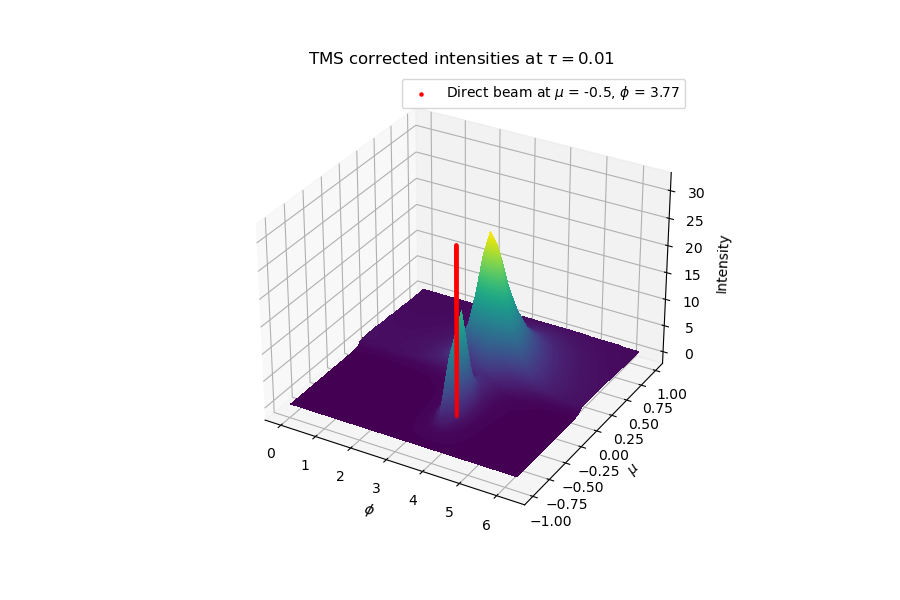

In [59]:
%matplotlib widget

tau_pt = 1e-2

plot = u_NT(tau_pt, phi_arr)[reorder_mu]

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(0, np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Intensity")
plt.title(r"TMS corrected intensities at $\tau =$" + str(tau_pt))
plt.legend()

In [60]:
LHS_NT = (
    mu_arr_RO[:, None]
    * ag.jacobian(lambda tau: u_NT(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS_NT = (
    u_NT(tau_pt, phi_arr)[reorder_mu]
    - (w0 / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr, g),
        u_NT(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (w0 * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0, g)
    * np.exp(-tau_pt / mu0)
)
error_NT = np.abs(RHS_NT - LHS_NT)

In [61]:
print("At tau = " + str(tau_pt))
print("Max pointwise error = ", np.max(error_NT))
print("Max pointwise error ratio =", np.max(error_NT / np.abs(LHS_NT)))

At tau = 0.01
Max pointwise error =  1.2973189641223826
Max pointwise error ratio = 5.886153123110296


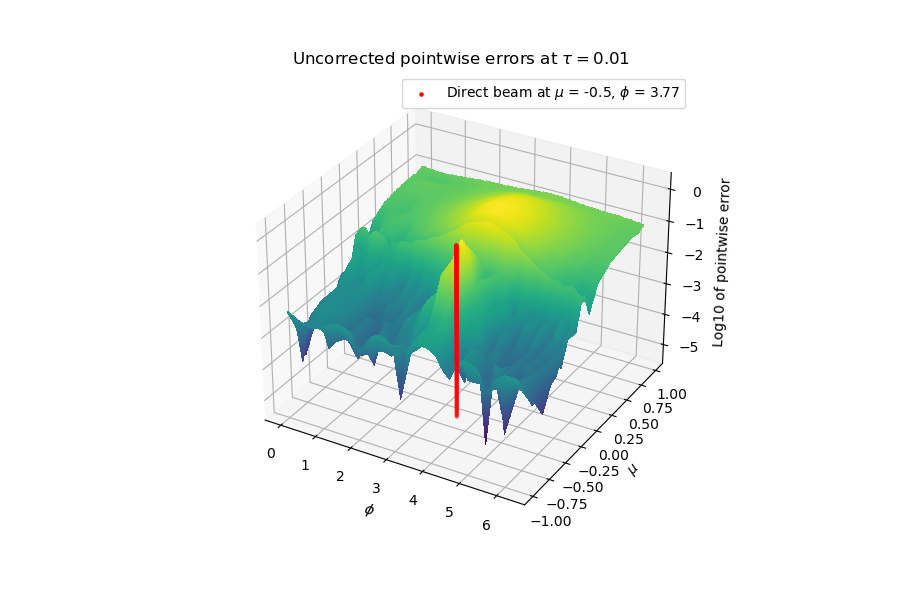

In [62]:
%matplotlib widget

plot = np.log10(error_NT)

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(np.min(plot), np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Log10 of pointwise error")
plt.title(r"Uncorrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

### 3.7.4 Computation of flux

PyDISORT also returns the positive and negative (hemispheric) flux functions. We have that

$$
F_\text{total}^\pm(\tau) = F_\text{diffuse}^\pm(\tau) + F_\text{direct}^\pm(\tau)
$$


**Direct (beam) flux**

Since the direct beam is

$$u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

and $\mu_0 > 0$, we have 

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

**Diffuse flux**

The diffuse flux equals

$$
\begin{aligned}
F_\text{diffuse}^\pm(\tau) &= \int_{0}^{1} \int_{0}^{2 \pi} \mu u\left(\tau, \pm\mu, \phi\right) \mathrm{d} \phi \mathrm{d} \mu \\
&= \sum_{m=0}^\infty \left(\int_{0}^{1} \mu u^m(\tau, \pm\mu) \mathrm{d} \mu \int_{0}^{2 \pi} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \phi \right) \\
&= 2\pi \int_{0}^{1} \mu u^0\left(\tau, \pm\mu\right) \mathrm{d} \mu \\
&\approx 2\pi \sum_{i = 1} w_i\mu_i u^0\left(\tau, \pm\mu_i\right)
\end{aligned}
$$

where we used the cosine expansion of $u$ from section [3.2](#3.2-Derivation-of-the-integro-differential-equation-for-each-Fourier-mode). In the last line we approximated the $\mu$ integral by some quadrature rule. Only the $0$th moment matters for the flux.

$$
F_\text{direct}^-(\tau) \equiv (1 + \omega_0 f) I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right), \quad F_\text{diffuse}^\pm(\tau^*_0) \approx 2\pi \sum_{i = 1} w_i\mu_i u^{*0}\left(\tau^*_0, \pm\mu_i\right)
$$

The upwelling and downwelling are respectively 

$$F_\text{total}^+(0), \quad F_\text{total}^-(\tau_0)$$ 

**Impact of $\delta-M$ scaling on flux calculations**

When we perform $\delta-M$ scaling we artificially augment the direct beam at the expense of the diffuse radiation. If we only cared about the total upward and downward flux, then our calculations are identical to above. If we wish to distinguish between direct and diffuse fluxes like in PyDISORT and Stamnes' DISORT [[2]](#cite-STWJ1988), however, then we need to exercise more caution. The direct fluxes must be

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

With $\delta-M$ scaling, however, we get a larger value for the downward direct flux since the direct beam was augmented,

$$F_\text{direct}^-(\tau^*) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau^*\right) > I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

The solution is simply to re-classify the additional downward flux from direct to diffuse.

#### 3.7.4.1 Verification of flux

[Skip verifications](#3.7.4.2-Reflectance-and-transmittance)

**Does integrating the intensity functions produce the flux functions?**

This test will fail if `callable(p_for_NT_with_g[0]) == True` because the corrections are applied only to the intensity and not the fluxes. This test will have to be changed if $\delta-M$ scaling is activated.

In [63]:
Ntau = 1000 # Number of tau test points
tau_arr = np.random.random(Ntau) * tau0

# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1  
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)

In [64]:
# No delta-scaling
u, flux_up, flux_down = PyDISORT.pydisort(
    b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0,
)[1:]
u_cache = u(tau_arr, phi_arr)

In [65]:
flux_up_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[:N, :],
    weights_mu,
    full_weights_phi,
    optimize=True,
)
flux_down_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[N:, :],
    weights_mu,
    full_weights_phi,
    optimize=True,
)

In [66]:
print("Flux up")
print(
    "Max pointwise error = ",
     np.linalg.norm(flux_up(tau_arr) - flux_up_test, ord=np.infty),
)
print()
print("Flux down (diffuse only)")
print(
    "Max pointwise error = ",
    np.linalg.norm(flux_down(tau_arr)[0] - flux_down_test, ord=np.infty),
)

Flux up
Max pointwise error =  4.4536181764698313e-07

Flux down (diffuse only)
Max pointwise error =  1.3124326017077692e-06


**Does $\delta-M$ scaling result in more accurate fluxes?**

In [67]:
# Fluxes without delta-scaling
flux_up, flux_down = PyDISORT.pydisort(
    0, 0, True, NLeg_full, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0, f=0
)[1:]

# Fluxes with delta-scaling
flux_up_dS, flux_down_dS = PyDISORT.pydisort(
    0, 0, True, NLeg_full, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0, f=f
)[1:]

# Fluxes calculated using a large number of phase function Legendre coefficients
flux_up_true, flux_down_true = PyDISORT.pydisort(
    0, 0, True, NLeg_full, NLoops, Leg_coeffs_full, tau0, w0, mu0, phi0, I0
)[1:]

In [68]:
print("Without delta-scaling, i.e. f =", 0)
print()
print("Flux up: Max pointwise error =", np.abs(flux_up(0) - flux_up_true(0)))
print("Flux down: Max pointwise error =", np.abs(np.sum(flux_down(tau0), axis=0) - np.sum(flux_down_true(tau0), axis=0)))
print()

print("With delta-scaling, f =", f)
print()
print("Flux up: Max pointwise error =", np.abs(flux_up_dS(0) - flux_up_true(0)))
print("Flux down: Max pointwise error =", np.abs(np.sum(flux_down_dS(tau0), axis=0) - np.sum(flux_down_true(tau0), axis=0)))

Without delta-scaling, i.e. f = 0

Flux up: Max pointwise error = 0.06291991721918944
Flux down: Max pointwise error = 0.0002891764818966358

With delta-scaling, f = 0.18530201888518416

Flux up: Max pointwise error = 0.002428175762722695
Flux down: Max pointwise error = 1.7313916384598116e-05


#### 3.7.4.2 Reflectance and transmittance

**Incident flux**

In order to compute the reflectance and transmittance, we first need to determine the incident flux. The incident flux from the direct beam is $I_0 \mu_0$. With $\delta-M$ scaling, the apparent direct flux becomes $(1 + \omega_0 f) I_0 \mu_0$. Of course the true direct flux remains $I_0 \mu_0$. This discrepancy is explained in [[7]](#cite-MW1980): under $\delta-M$ scaling, the apparent direct flux "includes scattered radiation traveling in very nearly the same direction as the incident beam".

Recall that the boundary conditions are

$$
u\left(\tau_0, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLoops}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLoops}}b^-_{im}\cos(m(\phi_0 - \phi)) \quad i = 1, \dots, N
$$

The incident flux from the BCs, which we denote $F_{b^\pm}$, are

$$F_{b^\pm} = 2 \pi \sum_{i = 0}^N w_i \mu_i b^\pm_{i0}$$

respectively, where $w_i$ are quadrature weights.  Once again, only the $0$th moment matters for the flux. If the BCs are constant over $\mu$, we will instead have 

$$F_{b^\pm} = \pi b^\pm$$

**Computation and interpretation of reflectance and transmittance values**

Reflectance, $R$, and transmittance, $T$, values only make sense if the incident radiation comes entirely from one side of the atmosphere, usually downward onto the top layer. Moreover, we generally want to calculate reflectance and transmittance with respect to a specific source. As an example, we calculate the reflectance and transmittance with respect to the direct beam:

$$R = \frac{F_\text{Total}^+(0)}{I_0 \mu_0}, \quad T = \frac{F_\text{Total}^-(\tau_0)}{I_0 \mu_0}$$

which requires us to set the BCs $b^\pm = 0$.

In [69]:
flux_up, flux_down = PyDISORT.pydisort(0, 0, True, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0, f=f)[1:3]


print("Reflectance, R =", flux_up(0) / (I0 * mu0))
print("Transmittance, T =", np.sum(flux_down(tau0), axis=0) / (I0 * mu0))

Reflectance, R = 0.059247800064207906
Transmittance, T = 0.0169875768073577


**Verification of reflectance and transmittance**

[Skip verification](#3.7.5-Timing-PyDISORT)

**Are $R$ and $T$ independent of the incident flux?**

In [70]:
num_of_tests = 100
min_I0, max_I0 = 0, 1e10


def test():
    for i in range(num_of_tests):
        I0_test = np.random.uniform(min_I0, max_I0)
        flux_up, flux_down = PyDISORT.pydisort(
            0, 0, True, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0_test, f=f
        )[1:3]
        R = flux_up(0) / (I0_test * mu0)
        T = np.sum(flux_down(tau0), axis=0) / (I0_test * mu0)

        I0_test = np.random.uniform(min_I0, max_I0)
        flux_up, flux_down = PyDISORT.pydisort(
            0, 0, True, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0_test, f=f
        )[1:3]
        assert np.isclose(R, flux_up(0) / (I0_test * mu0))
        assert np.isclose(T, np.sum(flux_down(tau0), axis=0) / (I0_test * mu0))
test()
print("Passed all tests")

Passed all tests


### 3.7.5 Timing PyDISORT

[Skip section](#4.-Solving-for-multiple-atmospheric-layers----TODO)

The time taken will of course be parameter-dependent, but this should give a sense of the speed of PyDISORT. The parameters that affect the speed of PyDISORT the most are

In [71]:
print("NQuad, NLoops, NLeg =", NQuad, NLoops, NLeg)

NQuad, NLoops, NLeg = 16 16 16


**Time taken to solve the radiative transfer equation**

In [72]:
'''print("Intensity")
%timeit PyDISORT.pydisort(b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0)
print()

print("Intensity with corrections")
%timeit PyDISORT.pydisort(b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0, f=f, p_for_NT=p_for_NT)
print()

print("Only fluxes")
%timeit PyDISORT.pydisort(b_pos, b_neg, True, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0)'''

'print("Intensity")\n%timeit PyDISORT.pydisort(b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0)\nprint()\n\nprint("Intensity with corrections")\n%timeit PyDISORT.pydisort(b_pos, b_neg, False, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0, f=f, p_for_NT=p_for_NT)\nprint()\n\nprint("Only fluxes")\n%timeit PyDISORT.pydisort(b_pos, b_neg, True, NQuad, NLoops, Leg_coeffs, tau0, w0, mu0, phi0, I0)'

**Time taken to evaluate the solution at a point**

In [73]:
'''print("Intensity")
%timeit u(tau_arr[Ntau//2], phi_arr[Nphi//2])
print()

print("Intensity with corrections")
%timeit u_NT(tau_arr[Ntau//2], phi_arr[Nphi//2])
print()

print("Fluxes")
%timeit flux_up(0)
%timeit flux_down(tau0)'''

'print("Intensity")\n%timeit u(tau_arr[Ntau//2], phi_arr[Nphi//2])\nprint()\n\nprint("Intensity with corrections")\n%timeit u_NT(tau_arr[Ntau//2], phi_arr[Nphi//2])\nprint()\n\nprint("Fluxes")\n%timeit flux_up(0)\n%timeit flux_down(tau0)'

# 4. Solving for multiple atmospheric layers -- TODO

If we have multiple atmospheric layers, they will be linked through their BCs. Notice that we only use the BCs to solve for the coefficients of the homogeneous solution. Hence, we solve for multiple atmospheric layers by looping through the single layer solver for each layer before solving for the coefficients of every homogeneous solution simultaneously through a generalization of section [3.6.2](#3.6.2-The-homogeneous-solution).

**Multi-layer generalization of section [3.6.2](#3.6.2-The-homogeneous-solution)**

We add a subscript to index the atmospheric layer. For $L$ atmospheric layers we have that $\tau_L = \tau_0$. Suppose we have $L=3$ atmospheric layers demarcated by $[0, \tau_1]$, $[\tau_1, \tau_2]$, $[\tau_2, \tau_3]$, and with homogeneous solutions $w_1$, $w_2$, $w_3$. We have the BCs

$$
\begin{aligned}
&w_1^-\left(0\right) = b^-_m - B_1^-, &&w_1^+\left(\tau_1\right) + B_1^+\exp\left(-\mu_0^{-1} \tau_1\right) = w_2^+\left(\tau_1\right) + B_2^+\exp\left(-\mu_0^{-1} \tau_1\right) \\
&w_2^-\left(\tau_1\right) + B_2^-\exp\left(-\mu_0^{-1} \tau_1\right) = w_1^-\left(\tau_1\right) + B_1^-\exp\left(-\mu_0^{-1} \tau_1\right), &&w_2^+\left(\tau_2\right) + B_2^+\exp\left(-\mu_0^{-1} \tau_2\right) = w_3^+\left(\tau_2\right) + B_2^+\exp\left(-\mu_0^{-1} \tau_2\right) \\
&w_3^-\left(\tau_2\right) + B_3^-\exp\left(-\mu_0^{-1} \tau_2\right) = w_2^-\left(\tau_2\right) + B_2^-\exp\left(-\mu_0^{-1} \tau_2\right), && w_3^+\left( \tau_0 \right) = b^+_m - B_3^+\exp\left(-\mu_0^{-1} \tau_0\right)
\end{aligned}
$$

where $B^\pm_i$ comes from the particular solution for each atmospheric layer and are therefore known. Denote $E_j = \text{Diag}\left(K_i\left(\tau_j\right)\right)$, the subscript index $i$ of $K_i$ can be omitted since it will always match that of $G_i$. The BCs produce the system

$$
\begin{bmatrix} 
G^-_1 & 0 & 0 \\ 
G^+_1 E_1 & -G^+_2 E_1 & 0 \\ 
-G^-_1 E_1 & G^-_2 E_1 & 0 \\ 
0 & G^+_2 E_2 & -G^+_3 E_2 \\ 
0 & -G^-_2 E_2 & G^-_3 E_2 \\
0 & 0 & G^+_3 E_0
\end{bmatrix} 
\begin{bmatrix} 
\xi_1 \\ 
\xi_2 \\ 
\xi_3 
\end{bmatrix} 
= 
\begin{bmatrix} b^-_m - B^-_1 \\ 
\left(B^+_2 - B^+_1\right)\exp\left(-\mu_0^{-1} \tau_1\right) \\
\left(B^-_1 - B^-_2\right)\exp\left(-\mu_0^{-1} \tau_1\right) \\ 
\left(B^+_3 - B^+_2\right)\exp\left(-\mu_0^{-1} \tau_2\right) \\ 
\left(B^-_2 - B^-_3\right)\exp\left(-\mu_0^{-1} \tau_2\right) \\ 
b^+_m - B^+_3 \exp\left(-\mu_0^{-1} \tau_0\right) 
\end{bmatrix}
$$

Further denote $E^\pm_j = \text{Diag}\left(K^\pm_i\left(\tau_j\right)\right)$. The multi-layer Stamnes-Conklin's substitutions [[4]](#cite-SC1984) are 

$$
\begin{aligned}
&\xi_1^- = C_1^- &&\xi_1^+ = C_1^+ E^-_1 \\
&\xi_2^- = C_2^- E^+_1 &&\xi_2^+ = C_2^+ E^-_2 \\
&\xi_3^- = C_3^- E^+_2 &&\xi_3^+ = C_3^+ E^-_3
\end{aligned}
$$

Recall that the eigenvalues are arranged negative then positive, e.g. $G^+_1 E_1 = \begin{bmatrix} G^{+-}_1 E^-_1 & G^{++}_1 E^+_1 \end{bmatrix}$. Further denote $E^\pm_{jk} = \text{Diag}\left(K^\pm_i\left(\tau_j - \tau_k\right)\right)$. The post-substitution system is

$$
\begin{bmatrix} 
G^{--}_1 & G^{-+}_1 E^-_1 & 0 & 0 & 0 & 0 \\ 
G^{+-}_1 E^-_1 & G^{++}_1 & -G^{+-}_2 & -G^{++}_2 E^-_{21} & 0 & 0 \\ 
-G^{--}_1 E^-_1 & -G^{-+}_1 & G^{--}_2 & G^{-+}_2 E^-_{21} & 0 & 0 \\ 
0 & 0 & G^{+-}_2 E^-_{21} & G^{++}_2 & -G^{+-}_3 & -G^{++}_3 E^-_{32} \\ 
0 & 0 & -G^{--}_2 E^-_{21} & -G^{-+}_2 & G^{--}_3 & G^{-+}_3 E^-_{32} \\
0 & 0 & 0 & 0 & G^{+-}_3 E^-_{32} & G^{++}_3
\end{bmatrix} 
\begin{bmatrix} 
C^-_1 \\ 
C^+_1 \\ 
C^-_2 \\ 
C^+_2 \\ 
C^-_3 \\
C^+_3 \\
\end{bmatrix} 
= 
\begin{bmatrix} b^-_m - B^-_1 \\ 
\left(B^+_2 - B^+_1\right)\exp\left(-\mu_0^{-1} \tau_1\right) \\
\left(B^-_1 - B^-_2\right)\exp\left(-\mu_0^{-1} \tau_1\right) \\ 
\left(B^+_3 - B^+_2\right)\exp\left(-\mu_0^{-1} \tau_2\right) \\ 
\left(B^-_2 - B^-_3\right)\exp\left(-\mu_0^{-1} \tau_2\right) \\ 
b^+_m - B^+_3 \exp\left(-\mu_0^{-1} \tau_0\right) 
\end{bmatrix}
$$

which is always well-conditioned. Note that $\tau_3 = \tau_0$.

*TODO: Change exposition to $L$ atmospheric layers instead of the current 3? Discuss de-coupling of system for small $\omega_0$.* 

*TODO: Add discussions on other changes required for a multi-layer solver like changes to the inputs and changes to the corrections? These write-ups can be in their own (sub)sections.*

*TODO: For a multi-layer system, discuss $R_{\text{sys}}$, Lambertian surface and even BDRF?*

# 5. Comparisons with Stamnes' FORTRAN DISORT -- TODO

`mu_arr` is arranged as it is for code efficiency and readability. For presentation purposes we re-arrange `mu_arr` from smallest to largest.

In [74]:
mu_arr, u_NT, flux_up, flux_down = PyDISORT.pydisort(
    0, 0, 
    False, 
    NQuad, NLoops, Leg_coeffs, 
    tau0, w0, 
    mu0, phi0, I0, 
    f=f, p_for_NT=p_for_NT,
)

In [75]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1  
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)

reorder_mu = np.argsort(mu_arr)

full_weights_mu_RO = full_weights_mu[reorder_mu]
mu_arr_RO = mu_arr[reorder_mu]

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

In [76]:
Ntau = 5 # Number of tau test points
tau_arr = np.random.random(Ntau) * tau0
#tau_arr = np.array([0, tau0])

In [77]:
# Test Problem 3:  Henyey-Greenstein Scattering, g = 0.9 (Compare To Ref. VH2, Table 37)
nlyr = 1
nmom = NLeg + 1 # The additional Legendre coefficient is used as f
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
#ntau = Ntau_deriv
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([True, False, False, False, False])  # Prints to CMD instead of here
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau0
ssalb = w0
pmom = Leg_coeffs_full[:NLeg + 1]
# pmom = np.append(Leg_coeffs, f) # Equivalent to above
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_arr
#utau = tau_arr_deriv
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = "Test Problem 3:  Henyey-Greenstein Scattering, g = 0.9 (Compare To Ref. VH2, Table 37)"
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

# More practically, if desired print the "disort" function's inputs and outputs
# print(disort.disort.__doc__)

In [78]:
# Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                        pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                        temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                        rfldn, flup, dfdt, uavg, uu, albmed, trnmed)

**Flux comparisons**

In [79]:
print("Difference ratios")
print()
print("Upward (diffuse) fluxes")
print(np.abs(flup - flux_up(tau_arr)) / np.clip(flup, a_min=1e-3, a_max=None))
print()
print("Downward (diffuse) fluxes")
print(np.abs(rfldn - flux_down(tau_arr)[0]) / np.clip(rfldn, a_min=1e-3, a_max=None))
print()
print("Direct (downward) fluxes")
print(np.abs(rfldir - flux_down(tau_arr)[1]) / np.clip(rfldir, a_min=1e-3, a_max=None))

Difference ratios

Upward (diffuse) fluxes
[7.26763617e-07 8.68660946e-07 1.22017076e-06 1.05194993e-06
 9.21916621e-07]

Downward (diffuse) fluxes
[3.90264110e-07 7.32469580e-08 6.57833613e-08 8.44589999e-08
 2.44559614e-07]

Direct (downward) fluxes
[2.92425116e-08 3.79337272e-09 1.46664896e-07 4.36444895e-08
 7.87144295e-08]


**Intensity comparisons**

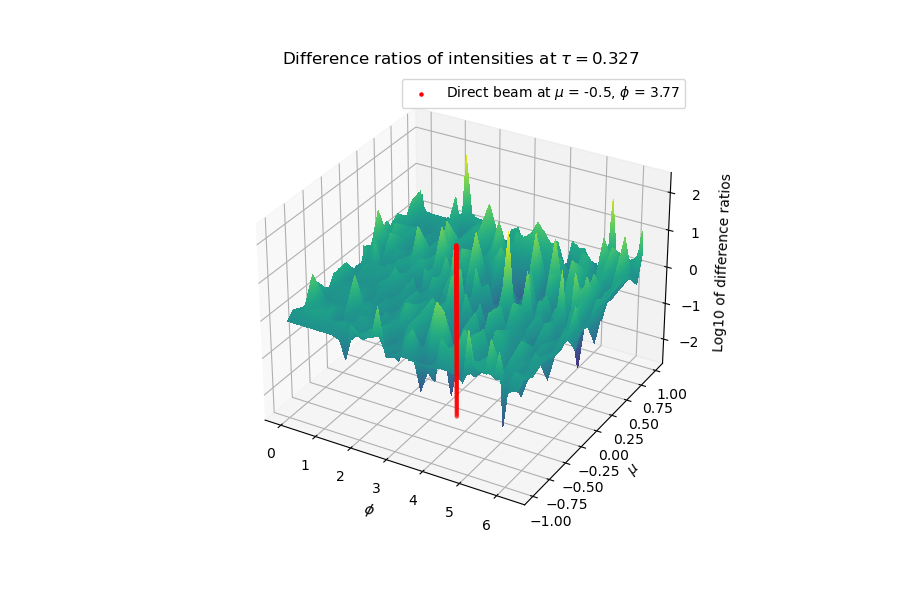

In [80]:
%matplotlib widget

index = 0
tau_pt = tau_arr[index]

plot = np.log10(
    np.abs(uu[:, index, :] - u_NT(tau_pt, phi_arr)[reorder_mu])
    / np.clip(np.abs(uu[:, index, :]), a_min=1e-3, a_max=None)
)

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contourf(MU_ARR, PHI_ARR, plot, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(np.min(plot), np.max(plot), 200) * 1.1,
    marker=".",
    color="red",
    label="Direct beam at $\mu$ = "
    + str(-mu0)
    + ", $\phi$ = "
    + str(np.around(phi0, 3)),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Log10 of difference ratios")
plt.title(r"Difference ratios of intensities at $\tau =$" + str(np.around(tau_pt, 3)))
plt.legend()

In [81]:
print("At tau = " + str(tau_pt))
print(
    "Max pointwise difference = ",
    np.max(np.abs(uu[:, index, :] - u_NT(tau_pt, phi_arr)[reorder_mu])),
)
print(
    "Max pointwise difference ratio =",
    np.max(
        np.abs(uu[:, index, :] - u_NT(tau_pt, phi_arr)[reorder_mu])
        / np.clip(np.abs(uu[:, index, :]), a_min=1e-3, a_max=None),
    ),
)

At tau = 0.3270497908604213
Max pointwise difference =  73.62952412950483
Max pointwise difference ratio = 98.75864990932727


**Timing Stamnes' DISORT (wrapped using F2PY)**

In [82]:
'''print("Intensity")
%timeit disort.disort(usrang, usrtau, ibcnd, False, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
print()

print("Only fluxes")
%timeit disort.disort(usrang, usrtau, ibcnd, True, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)'''

'print("Intensity")\n%timeit disort.disort(usrang, usrtau, ibcnd, False, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)\nprint()\n\nprint("Only fluxes")\n%timeit disort.disort(usrang, usrtau, ibcnd, True, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)'

<!--bibtex

@article{NT1988,
title = {Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {40},
number = {1},
pages = {51-69},
year = {1988},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(88)90031-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407388900313},
author = {T. Nakajima and M. Tanaka},
abstract = {The efficiency of numerical calculations is discussed for selected algorithms employing the discrete ordinate method and the truncation approximation for the solar radiative intensity in moderately thick, plane-parallel scattering atmospheres. It is found that truncation of the phase function causes a significant error in the computed intensity and the magnitude of this error depends significantly on how the intensity is retrieved from the truncated radiative transfer equation. A newly developed retrieval algorithm, the TMS- method, yields the intensity field with an error ⪅1% when the number of discrete path is as small as 10 in the hemisphere for aerosol-laden atmospheres with optical thickness ⪅1.}
}

@article{YTA1971,
title = {Radiative heat transfer in water clouds by infrared radiation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {11},
number = {6},
pages = {697-708},
year = {1971},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(71)90048-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407371900483},
author = {Giichi Yamamoto and Masayuki Tanaka and Shoji Asano},
abstract = {Radiative heat transfer in water clouds is studied by the method of discrete ordinates, taking into account not only scattering, absorption and emission by cloud droplets but also absorption and emission by water vapor in the cloud. According to Semuelson the method of discrete ordinates is not very amenable to studies involving the intermediate optical thickness, because of instabilities that are inherent in the method for the intermediate optical thickness. A method of avoiding these instabilities is shown in this paper. Numerical calculation for the spectral region from 5 to 40 μ was carried out on the model altostratus clouds, and that only for the window region on the model stratocumulus and nimbostratus clouds. The radiative temperature change in a very thin cloud is everywhere cooling. With increasing cloud thickness, however, the upper parts of the cloud undergo cooling, while the lower parts undergo heating. The rate of both heating and cooling is largest near the surface. In a semi-infinitely thick cloud the cloud top undergoes cooling at a rate of about 30°C/hr and effective cooling extends to about 100 m interior from the cloud boundary.}
}

@book{Cha1960, 
      author = "S.  Chandrasekhar",
      title = "Radiative Transfer",
      year = "1960",
      publisher = "Dover",
}

@article{Wis1977,
      author = "W. J.  Wiscombe",
      title = "The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions",
      journal = "Journal of Atmospheric Sciences",
      year = "1977",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "34",
      number = "9",
      doi = "10.1175/1520-0469(1977)034<1408:TDMRYA>2.0.CO;2",
      pages=      "1408 - 1422",
      url = "https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml"
}

@article{Syk1951,
    author = {Sykes, J. B.},
    title = "{Approximate Integration of the Equation of Transfer}",
    journal = {Monthly Notices of the Royal Astronomical Society},
    volume = {111},
    number = {4},
    pages = {377-386},
    year = {1951},
    month = {08},
    abstract = "{The value of numerical integration in obtaining approximate solutions of an equation of transfer, and the different methods at our disposal, are discussed. It is shown that although the Newton-Cotes method, used by Kourganoff, is better than the Gauss method, used by Chandrasekhar, both are inferior to a new method, the double-Gauss, discovered by the author. The errors in the approximate values of the source-function and the limb-darkening in all three methods are tabulated for various approximations, and illustrated by graphs.}",
    issn = {0035-8711},
    doi = {10.1093/mnras/111.4.377},
    url = {https://doi.org/10.1093/mnras/111.4.377},
    eprint = {https://academic.oup.com/mnras/article-pdf/111/4/377/8077435/mnras111-0377.pdf},
}


@article{STWJ1988,
author = {Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera},
journal = {Appl. Opt.},
keywords = {Electromagnetic radiation; Multiple scattering; Optical depth; Radiative transfer; Reflection; Thermal emission},
number = {12},
pages = {2502--2509},
publisher = {Optica Publishing Group},
title = {Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media},
volume = {27},
month = {Jun},
year = {1988},
url = {http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502},
doi = {10.1364/AO.27.002502},
abstract = {We summarize an advanced, thoroughly documented, and quite general purpose discrete ordinate algorithm for time-independent transfer calculations in vertically inhomogeneous, nonisothermal, plane-parallel media. Atmospheric applications ranging from the UV to the radar region of the electromagnetic spectrum are possible. The physical processes included are thermal emission, scattering, absorption, and bidirectional reflection and emissionat the lower boundary. The medium may be forced at the top boundary by parallel or diffuse radiation and by internal and boundary thermal sources as well. We provide a brief account of the theoretical basis as well as a discussion of the numerical implementation of the theory. The recent advances made by ourselves and our collaborators---advances in both formulation and numerical solution---are all incorporated in the algorithm. Prominent among these advances are the complete conquest of two ill-conditioning problems which afflicted all previous discrete ordinate implementations: (1) the computation of eigenvalues and eigenvectors and (2) the inversion of the matrix determining the constants of integration. Copies of the fortran program on microcomputer diskettes are available for interested users.},
}



@article{STWLE2000,
author = {Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco},
year = {2000},
month = {02},
pages = {},
title = {General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT}
}

@article{SS1981,
      author = "Knut  Stamnes and Roy A.  Swanson",
      title = "A New Look at the Discrete Ordinate Method for Radiative Transfer Calculations in Anisotropically Scattering Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1981",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "38",
      number = "2",
      doi = "10.1175/1520-0469(1981)038<0387:ANLATD>2.0.CO;2",
      pages=      "387 - 399",
      url = "https://journals.ametsoc.org/view/journals/atsc/38/2/1520-0469_1981_038_0387_anlatd_2_0_co_2.xml"
}

@article{SC1984,
title = {A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {31},
number = {3},
pages = {273-282},
year = {1984},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(84)90031-1},
url = {https://www.sciencedirect.com/science/article/pii/0022407384900311},
author = {Knut Stamnes and Paul Conklin},
abstract = {A recently developed matrix formulation of the discrete ordinate method is extended for application to an inhomogeneous atmosphere. The solution yields fluxes, as well as the complete azimuthal dependence of the intensity at any level in the atmosphere. The numerical aspects of the solution are discussed and numerical verification is provided by comparing computed results with those obtained by other methods. In particular, it is shown that a simple scaling scheme, which removes the positive exponentials in the coefficient matrix when solving for the constants of integration, provides unconditionally stable solutions for arbitrary optical thicknesses. An assessment of the accuracy to be expected is also provided, and it is shown that low-order discrete ordinate approximations yield very accurate flux values.}
}

@article{MH2017,
title = {A demonstration of adjoint methods for multi-dimensional remote sensing of the atmosphere and surface},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {204},
pages = {215-231},
year = {2018},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2017.09.031},
url = {https://www.sciencedirect.com/science/article/pii/S0022407317305198},
author = {William G.K. Martin and Otto P. Hasekamp},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives, Searchlight functions},
abstract = {In previous work, we derived the adjoint method as a computationally efficient path to three-dimensional (3D) retrievals of clouds and aerosols. In this paper we will demonstrate the use of adjoint methods for retrieving two-dimensional (2D) fields of cloud extinction. The demonstration uses a new 2D radiative transfer solver (FSDOM). This radiation code was augmented with adjoint methods to allow efficient derivative calculations needed to retrieve cloud and surface properties from multi-angle reflectance measurements. The code was then used in three synthetic retrieval studies. Our retrieval algorithm adjusts the cloud extinction field and surface albedo to minimize the measurement misfit function with a gradient-based, quasi-Newton approach. At each step we compute the value of the misfit function and its gradient with two calls to the solver FSDOM. First we solve the forward radiative transfer equation to compute the residual misfit with measurements, and second we solve the adjoint radiative transfer equation to compute the gradient of the misfit function with respect to all unknowns. The synthetic retrieval studies verify that adjoint methods are scalable to retrieval problems with many measurements and unknowns. We can retrieve the vertically-integrated optical depth of moderately thick clouds as a function of the horizontal coordinate. It is also possible to retrieve the vertical profile of clouds that are separated by clear regions. The vertical profile retrievals improve for smaller cloud fractions. This leads to the conclusion that cloud edges actually increase the amount of information that is available for retrieving the vertical profile of clouds. However, to exploit this information one must retrieve the horizontally heterogeneous cloud properties with a 2D (or 3D) model. This prototype shows that adjoint methods can efficiently compute the gradient of the misfit function. This work paves the way for the application of similar methods to 3D remote sensing problems.}
}

@article{MCB2014,
title = {Adjoint methods for adjusting three-dimensional atmosphere and surface properties to fit multi-angle/multi-pixel polarimetric measurements},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {144},
pages = {68-85},
year = {2014},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2014.03.030},
url = {https://www.sciencedirect.com/science/article/pii/S002240731400154X},
author = {William Martin and Brian Cairns and Guillaume Bal},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives},
abstract = {This paper derives an efficient procedure for using the three-dimensional (3D) vector radiative transfer equation (VRTE) to adjust atmosphere and surface properties and improve their fit with multi-angle/multi-pixel radiometric and polarimetric measurements of scattered sunlight. The proposed adjoint method uses the 3D VRTE to compute the measurement misfit function and the adjoint 3D VRTE to compute its gradient with respect to all unknown parameters. In the remote sensing problems of interest, the scalar-valued misfit function quantifies agreement with data as a function of atmosphere and surface properties, and its gradient guides the search through this parameter space. Remote sensing of the atmosphere and surface in a three-dimensional region may require thousands of unknown parameters and millions of data points. Many approaches would require calls to the 3D VRTE solver in proportion to the number of unknown parameters or measurements. To avoid this issue of scale, we focus on computing the gradient of the misfit function as an alternative to the Jacobian of the measurement operator. The resulting adjoint method provides a way to adjust 3D atmosphere and surface properties with only two calls to the 3D VRTE solver for each spectral channel, regardless of the number of retrieval parameters, measurement view angles or pixels. This gives a procedure for adjusting atmosphere and surface parameters that will scale to the large problems of 3D remote sensing. For certain types of multi-angle/multi-pixel polarimetric measurements, this encourages the development of a new class of three-dimensional retrieval algorithms with more flexible parametrizations of spatial heterogeneity, less reliance on data screening procedures, and improved coverage in terms of the resolved physical processes in the Earth׳s atmosphere.}
}

@article{LSJLTWS2015,
title = {Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {157},
pages = {119-134},
year = {2015},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2015.02.014},
url = {https://www.sciencedirect.com/science/article/pii/S0022407315000679},
author = {Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes},
keywords = {Radiative transfer model, BRDF, Cox–Munk, Ross–Li, RPV, Single scattering correction},
abstract = {A successor version 3 of DISORT (DISORT3) is presented with important upgrades that improve the accuracy, efficiency, and stability of the algorithm. Compared with version 2 (DISORT2 released in 2000) these upgrades include (a) a redesigned BRDF computation that improves both speed and accuracy, (b) a revised treatment of the single scattering correction, and (c) additional efficiency and stability upgrades for beam sources. In DISORT3 the BRDF computation is improved in the following three ways: (i) the Fourier decomposition is prepared “off-line”, thus avoiding the repeated internal computations done in DISORT2; (ii) a large enough number of terms in the Fourier expansion of the BRDF is employed to guarantee accurate values of the expansion coefficients (default is 200 instead of 50 in DISORT2); (iii) in the post-processing step the reflection of the direct attenuated beam from the lower boundary is included resulting in a more accurate single scattering correction. These improvements in the treatment of the BRDF have led to improved accuracy and a several-fold increase in speed. In addition, the stability of beam sources has been improved by removing a singularity occurring when the cosine of the incident beam angle is too close to the reciprocal of any of the eigenvalues. The efficiency for beam sources has been further improved from reducing by a factor of 2 (compared to DISORT2) the dimension of the linear system of equations that must be solved to obtain the particular solutions, and by replacing the LINPAK routines used in DISORT2 by LAPACK 3.5 in DISORT3. These beam source stability and efficiency upgrades bring enhanced stability and an additional 5–7% improvement in speed. Numerical results are provided to demonstrate and quantify the improvements in accuracy and efficiency of DISORT3 compared to DISORT2.}
}

@article {JWW1976,
      author = "J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman",
      title = "The Delta-Eddington Approximation for Radiative Flux Transfer",
      journal = "Journal of Atmospheric Sciences",
      year = "1976",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "33",
      number = "12",
      doi = "10.1175/1520-0469(1976)033<2452:TDEAFR>2.0.CO;2",
      pages=      "2452 - 2459",
      url = "https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml"
}

@Article{HMMNPW2017,
AUTHOR = {Hase, N. and Miller, S. M. and Maa{\ss}, P. and Notholt, J. and Palm, M. and Warneke, T.},
TITLE = {Atmospheric inverse modeling via sparse reconstruction},
JOURNAL = {Geoscientific Model Development},
VOLUME = {10},
YEAR = {2017},
NUMBER = {10},
PAGES = {3695--3713},
URL = {https://gmd.copernicus.org/articles/10/3695/2017/},
DOI = {10.5194/gmd-10-3695-2017}
}

@article {FL1992,
      author = "Qiang  Fu and K. N.  Liou",
      title = "On the Correlated k-Distribution Method for Radiative Transfer in Nonhomogeneous Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1992",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "49",
      number = "22",
      doi = "10.1175/1520-0469(1992)049<2139:OTCDMF>2.0.CO;2",
      pages=      "2139 - 2156",
      url = "https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml"
}

@inproceedings{FJ1999,
  title={Computer-based underwater imaging analysis},
  author={Georges R. Fournier and Miroslaw Jonasz},
  booktitle={Optics \& Photonics},
  year={1999}
}

@article{DM2010,
	doi = {10.1088/0034-4885/73/2/026801},
	url = {https://doi.org/10.1088/0034-4885/73/2/026801},
	year = 2010,
	month = {jan},
	publisher = {{IOP} Publishing},
	volume = {73},
	number = {2},
	pages = {026801},
	author = {Anthony B Davis and Alexander Marshak},
	title = {Solar radiation transport in the cloudy atmosphere: a 3D perspective on observations and climate impacts},
	journal = {Reports on Progress in Physics},
	abstract = {The interplay of sunlight with clouds is a ubiquitous and often pleasant visual experience, but it conjures up major challenges for weather, climate, environmental science and beyond. Those engaged in the characterization of clouds (and the clear air nearby) by remote sensing methods are even more confronted. The problem comes, on the one hand, from the spatial complexity of real clouds and, on the other hand, from the dominance of multiple scattering in the radiation transport. The former ingredient contrasts sharply with the still popular representation of clouds as homogeneous plane-parallel slabs for the purposes of radiative transfer computations. In typical cloud scenes the opposite asymptotic transport regimes of diffusion and ballistic propagation coexist. We survey the three-dimensional (3D) atmospheric radiative transfer literature over the past 50 years and identify three concurrent and intertwining thrusts: first, how to assess the damage (bias) caused by 3D effects in the operational 1D radiative transfer models? Second, how to mitigate this damage? Finally, can we exploit 3D radiative transfer phenomena to innovate observation methods and technologies? We quickly realize that the smallest scale resolved computationally or observationally may be artificial but is nonetheless a key quantity that separates the 3D radiative transfer solutions into two broad and complementary classes: stochastic and deterministic. Both approaches draw on classic and contemporary statistical, mathematical and computational physics.}
}

@article{DFDM2021,
      author = "Linda Forster and Anthony B. Davis and David J. Diner and Bernhard Mayer",
      title = "Toward Cloud Tomography from Space Using MISR and MODIS: Locating the “Veiled Core” in Opaque Convective Clouds",
      journal = "Journal of the Atmospheric Sciences",
      year = "2021",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "78",
      number = "1",
      doi = "10.1175/JAS-D-19-0262.1",
      pages=      "155 - 166",
      url = "https://journals.ametsoc.org/view/journals/atsc/78/1/jas-d-19-0262.1.xml"
}

@article{DDET2022,
title = {Cloud tomographic retrieval algorithms. I: Surrogate minimization method},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {277},
pages = {107954},
year = {2022},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2021.107954},
url = {https://www.sciencedirect.com/science/article/pii/S0022407321004465},
author = {Adrian Doicu and Alexandru Doicu and Dmitry Efremenko and Thomas Trautmann},
keywords = {Cloud tomographic retrieval, Multi-dimensional models},
abstract = {A cloud tomographic retrieval algorithm relying on (i) the spherical harmonics discrete ordinate method for computing the radiative transfer and (ii) the surrogate minimization method for solving the inverse problem has been designed. The retrieval algorithm uses regularization, accelerated projected gradient methods, and two types of surrogate functions. The performances of the retrieval algorithm are analyzed on a few synthetic two- and three-dimensional problems.}
}

@misc{Sta1999, 
	title={LLLab disort website}, 
	url={http://www.rtatmocn.com/disort/}, 
	journal={Light and Life Lab (LLLab)}, 
	author={Stamnes, S.}, 
	year={1999}
} 

@INPROCEEDINGS{ALHSAV2020,
  author={Aides, Amit and Levis, Aviad and Holodovsky, Vadim and Schechner, Yoav Y. and Althausen, Dietrich and Vainiger, Adi},
  booktitle={2020 IEEE International Conference on Computational Photography (ICCP)}, 
  title={Distributed Sky Imaging Radiometry and Tomography}, 
  year={2020},
  volume={},
  number={},
  pages={1-12},
  doi={10.1109/ICCP48838.2020.9105241}}

@article {MW1980,
      author = "W. E.  Meador and W. R.  Weaver",
      title = "Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement",
      journal = "Journal of Atmospheric Sciences",
      year = "1980",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "37",
      number = "3",
      doi = "10.1175/1520-0469(1980)037<0630:TSATRT>2.0.CO;2",
      pages=      "630 - 643",
      url = "https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml"
}


-->

# References

<a id="cite-Cha1960"/><sup><a href=#ref-1>[^]</a><a href=#ref-21>[^]</a></sup>S.  Chandrasekhar. 1960. _Radiative Transfer_.

<a id="cite-STWJ1988"/><sup><a href=#ref-2>[^]</a><a href=#ref-7>[^]</a><a href=#ref-8>[^]</a><a href=#ref-16>[^]</a><a href=#ref-17>[^]</a><a href=#ref-19>[^]</a><a href=#ref-24>[^]</a><a href=#ref-28>[^]</a></sup>Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera. 1988. _Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media_. [URL](http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502)

<a id="cite-Sta1999"/><sup><a href=#ref-3>[^]</a><a href=#ref-5>[^]</a><a href=#ref-6>[^]</a><a href=#ref-9>[^]</a><a href=#ref-11>[^]</a><a href=#ref-13>[^]</a><a href=#ref-14>[^]</a></sup>Stamnes, S.. 1999. _LLLab disort website_. [URL](http://www.rtatmocn.com/disort/)

<a id="cite-SC1984"/><sup><a href=#ref-4>[^]</a><a href=#ref-25>[^]</a><a href=#ref-30>[^]</a></sup>Knut Stamnes and Paul Conklin. 1984. _A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres_. [URL](https://www.sciencedirect.com/science/article/pii/0022407384900311)

<a id="cite-Wis1977"/><sup><a href=#ref-10>[^]</a><a href=#ref-18>[^]</a></sup>W. J.  Wiscombe. 1977. _The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions_. [URL](https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml)

<a id="cite-JWW1976"/><sup><a href=#ref-12>[^]</a></sup>J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman. 1976. _The Delta-Eddington Approximation for Radiative Flux Transfer_. [URL](https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml)

<a id="cite-MW1980"/><sup><a href=#ref-15>[^]</a><a href=#ref-29>[^]</a></sup>W. E.  Meador and W. R.  Weaver. 1980. _Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement_. [URL](https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml)

<a id="cite-Syk1951"/><sup><a href=#ref-20>[^]</a></sup>Sykes, J. B.. 1951. _Approximate Integration of the Equation of Transfer_. [URL](https://doi.org/10.1093/mnras/111.4.377)

<a id="cite-STWLE2000"/><sup><a href=#ref-22>[^]</a><a href=#ref-23>[^]</a><a href=#ref-27>[^]</a></sup>Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco. 2000. _General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT_.

<a id="cite-NT1988"/><sup><a href=#ref-26>[^]</a></sup>T. Nakajima and M. Tanaka. 1988. _Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation_. [URL](https://www.sciencedirect.com/science/article/pii/0022407388900313)

